# Introduction


Hello! <br>
I am <b>Mirambika Sikdar</b> , an Outreachy Applicant from Indian Institute of Technology, Kharagpur, India. I have previously worked in the field of NLP, ML and Bioinformatics. After thinking about the review comments, I realised that I overlooked Data cleaning and the power of statistics. Then, I poured my heart and soul into trying to understand the data and hopefully can narrate the thought process in python way! 

# Libraries

In [ ]:
!pip install phik
!pip install shap
!pip install xgboost

In [ ]:
!git clone https://github.com/mozilla/outreachy-datascience-2021.git

fatal: destination path 'outreachy-datascience-2021' already exists and is not an empty directory.


Why these Libraries?

numpy,pandas,scipy,sklearn -> Provide easy data manipulation abilities, access to statistical tests and utilities such as imputers. 

**phik** -> <br>
a. It works consistently between categorical, ordinal and interval variables. <br>
b. It captures non-linear dependency. <br>
c. It reverts to the Pearson correlation coefficient in case of a bi-variate normal input distribution. <br>
Reference - https://arxiv.org/pdf/1811.11440.pdf <br>
Thankfully, I found a python implementation - https://phik.readthedocs.io/en/latest/index.html

**networkx** -> In the case of multiple features, it often becomes difficult to remember the interconnected correlations. A quick vizualization in 2D space can help us take note of relevant features/nodes. It's for this reason I used networkx to vizualize columns as nodes and edges as correlations.

**hyperopt** -> It is a powerful python library that search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function. It is much faster than grid search cv.

**Seaborn, matplotlib, Plotly** -> Provide quick visualizations. Visualizations are an equal, if not more, part of EDA as compared to raw numbers/measures. It's a general pattern that I follow to visualize -> get inferences -> confirm inferences through further visualizations/statistical measures -> re affirm through visualization. <br>
Plotly is an interactive and much more professional looking viz library. It provides additional utils like providing information while hovering cursor. However, seaborn can also be substituted to plotly. But, I try to learn a library/skill through practical tasks and hence decided to use it!



## Reading Files and Importing Libraries

In [ ]:
#Data Manipulation and Staistics
import pandas as pd
import numpy as np
from scipy.stats import kurtosis,skew,chi2_contingency
from sklearn.preprocessing import *
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
import math
import shap

#Correlation
import phik
import networkx as nx  

#Visualization
from string import Template
import plotly.express as px
import IPython.display
from plotly.offline import init_notebook_mode, iplot
from plotly import subplots
import plotly as py
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

#Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#Clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

import warnings
warnings.filterwarnings("ignore")


#Reading Data
df = pd.read_csv("outreachy-datascience-2021/initial_contribution/dataset.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Summary of Task

**Task 1** <br>
Identifying the feature that best 'describes' SalePrice variable. Since the PS states "feature in dataset.csv", I've restricted myself to columns in the dataset and considered feature engineering as a part of next task. However, throughout EDA, I'll try to list out possible ideas of feature engineering as I gather inferences.

**Task 2** <br>
Data preparation for modelling, Model selection, Model Validation

This notebook is divided into 3 categories:
1. Extensive EDA + Data Cleaning, which partly helps in removing redundant features to filter out/analyse the 'best feature' easily; and partly prepares the data for modelling. It is crucial for task 2
2. Task 1 + summary
3. Task 2 + summary

# First Hand at Data



This section is concerned with describing handling of data in the very beginning. This helps in outlining future methods better and highlight important characteristics of the dataset

## Description of Columns




In [ ]:
# SUMMARY OF THE COLUMNS :
file1 = open("outreachy-datascience-2021/initial_contribution/data_description.txt","r")
list_lines = file1.readlines()
final_str = ' '.join(list_lines)
print(final_str)

MSSubClass: Identifies the type of dwelling involved in the sale.	
 
         20	1-STORY 1946 & NEWER ALL STYLES
         30	1-STORY 1945 & OLDER
         40	1-STORY W/FINISHED ATTIC ALL AGES
         45	1-1/2 STORY - UNFINISHED ALL AGES
         50	1-1/2 STORY FINISHED ALL AGES
         60	2-STORY 1946 & NEWER
         70	2-STORY 1945 & OLDER
         75	2-1/2 STORY ALL AGES
         80	SPLIT OR MULTI-LEVEL
         85	SPLIT FOYER
         90	DUPLEX - ALL STYLES AND AGES
        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
        150	1-1/2 STORY PUD - ALL AGES
        160	2-STORY PUD - 1946 & NEWER
        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
        190	2 FAMILY CONVERSION - ALL STYLES AND AGES
 
 MSZoning: Identifies the general zoning classification of the sale.
 		
        A	Agriculture
        C	Commercial
        FV	Floating Village Residential
        I	Industrial
        RH	Residential High Density
        RL	Residential Low Density
        RP	Residential 

In [ ]:
#I found the search for description of columns tedious and hence, tried to consolidate them in a nice looking table 
values = []
value1=[]
value2=[]
for line in list_lines:
    if line.find(':')!=-1:
        value1.append(line.split(':')[0])
        value2.append(line.split(':')[1])
values.append(value1)
values.append(value2)

fig = go.Figure(data=[go.Table(
  columnorder = [1,2],
  columnwidth = [80,400],
  header = dict(
    values = [['<b>Column Name</b><br>as given in the text file'],
                  ['<b>DESCRIPTION</b>']],
    line_color=primary_black,
    fill_color=primary_blue2,
    align=['left','left'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color=primary_black,
    fill=dict(color=[primary_bgcolor,primary_grey]),
    align=['left', 'left'],
    font_size=12,
    height=30)
    )
], layout = dict(width=800,height=4000))
fig.show(renderer='colab')


Observations

---
How would a buyer look at these features? Since descriptions are provided, I can use them while interpreting correlations, feature engineering. 

## Basic Data Statistics

In [ ]:
# DATA STATISTICS 
def dataset_stats(df):
    numvars = len(df.columns)
    numobs = len(df)
    duprows = len(df) - len(df.drop_duplicates())
    missobs = np.sum(df.isna().values)
    fig =go.Figure()
    fig.add_trace(go.Table(
            columnwidth = [3,1],
            header = dict(values=['\t\t Data Statistics :'],                        
                        line_color= primary_blue3,
                        fill_color= primary_blue3,
                        font_color= "white",
                        font_size = 16,
                        height = 30,
                        align='left'),
            cells = dict(values=[["Number of Variables", "Number of Observations", "Number of Duplicate rows", "% Duplicate rows","Number of missing cells","% missing cells"], 
                               [str(numvars),str(numobs),str(duprows),str(100*duprows/numobs)+"%",str(missobs),str(100*missobs/(numvars*numobs))+"%"]], 
                        line_color='darkslategray',
                        line_width=0.5,
                        fill_color='white',
                        font_size = 15,
                        height = 28,
                       align=['left','center'])
            )
    )
    fig.show(renderer="colab")
    
dataset_stats(df)

Observations : <br>

---
1. High Dimensional dataset, but inadequate number of observations to capture the variance substantially. This means that I should look into ways of feature elimination. Even for Task 2, we know that keeping additional features has a computation cost and in some cases, might lead to overfitting.

2. Missing observations. 


## Missing Values in Data

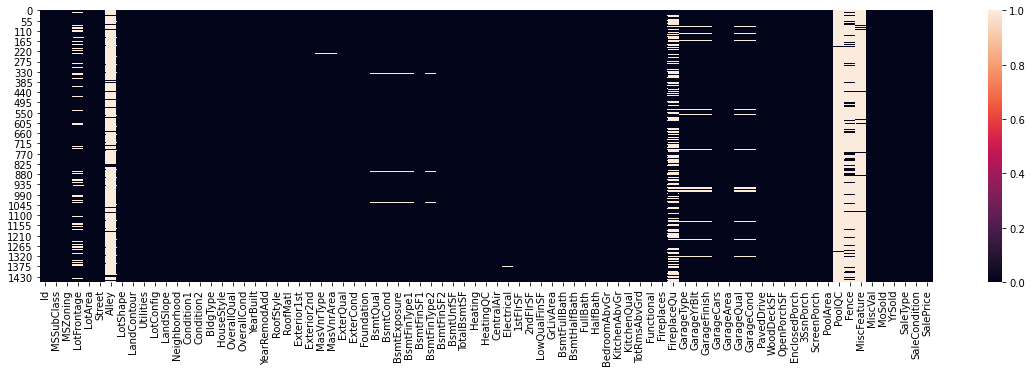

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isna())

Observations:


---

1. The missing cells are not random. Instead, they are shared by similar columns which means that there must be a pattern that is represented as np.nan. I was initially losing out on this information, so thanks for pointing out loss of information!

## Comparison of Unique Values in Columns (excl nan)

In [ ]:
cols = df.columns.tolist()
unique = pd.DataFrame([df[col].nunique() for col in cols])
unique.index = cols
unique.sort_values(by=0,ascending=False,inplace=True)

trace = go.Bar(
    y = unique.index.tolist(),
    x = unique[0].tolist(),
    name = "Unique values",
    orientation = "h",
    marker = dict(color = [primary_blue] + [primary_grey]*11),
    text = unique[0].tolist(),
    texttemplate =  "<b style='color: #202022'>%{text} </b>",
    textposition = "outside"
)
title_main = "<span style='font-size:24px; font-family:Times New Roman'> Comparison of no. of Unique values for columns</span>"
subtitle = "<span style='font-size:14px; font-family:Helvetica'>As can be observed, variables below <b>ScreenPorch</b> are continous (except <b>ID</b>).<br> <b>YearRemodAdd</b> and <b>YearBuilt</b> can be considered as time variables<br></span>"

layout = dict(
   title = title_main + "<br><br>" + subtitle,
    margin = dict(t=230),
    xaxis=dict(side="top", zerolinecolor = "#4d4d4d", zerolinewidth = 0.25, gridcolor="#e7e7e7"),
    width = 800,
    height= 2000,
    plot_bgcolor = "#fff"
)

fig = go.Figure(data = trace, layout = layout)
fig.show(renderer="colab")

Observations 


---
1. Mixture of continous and categorical variables. Some can be clearly seen as continous and categorical, while there are features in the middle with categorical description and unique values>15. Given the number of observations, it is highly likely that some of these columns might have overly represented classes and very rare classes. I should consider binning as feature transformation.

2. Initially it helped me understand that I should divide columns into categorical, numerical/continous and other to better handle the huge number of columns while doing EDA. However, after going through descriptions of columns as well as shared missing cells across 3-4 columns (establishing a common origination/meaning) - I realised that I should have a more closer look at the data. This means identifying sub categories and treating each separately, during primary data cleaning


## Target Variable

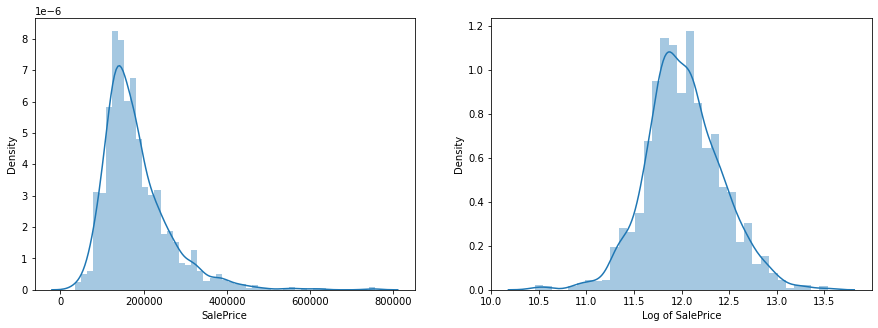

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df["SalePrice"])
plt.subplot(1,2,2)
sns.distplot(np.log(df["SalePrice"]),axlabel='Log of SalePrice')

Observations 

---
1. The target variable has a high skew value (Right skewed). It does make sense to expect very few people to be able to buy very high costly houses. However, there will always be extremely rich clients, although statistically 'outlier'.

2. I thought of this transformation because log compresses scales, especially for far away outliers.


## EDA of Columns wrt Target

In [ ]:
#Function to create a plotly figure 
# We need to observe the variable distribution and relation with Target

def collect_stats(df,col):
    '''
    Takes a dataframe df and a column. 
    Returns a plotly figure variable containing 
    1. Histogram to understand distribution of variable
    2. Scatterplot with target variable
    
    '''
    if col == "SalePrice":
        fig = px.histogram(df, x=col,marginal="box")
    else:
        fig = subplots.make_subplots(rows=2, cols=1, shared_xaxes=False,shared_yaxes=False,
                            horizontal_spacing = 0.02)      
        fig.add_trace(go.Histogram(
                    x=df[col],
                    opacity=0.75,
                    name=col + " Distribution"
                ), row=1,col=1
        )
                
        fig.add_trace(go.Scatter(
                    x=df["SalePrice"],
                    y=df[col],
                    opacity=0.50,
                    name='Column vs SalePrice',
                    yaxis='y2',
                    mode='markers'
                ),row=2,col=1
        )
        fig.update_xaxes(title_text=col,row=1, col=1)
        fig.update_xaxes(title_text="SalePrice",row=2, col=1)

        fig.update_yaxes(title_text="Frequency", row=1, col=1,showgrid=True)
        fig.update_yaxes(title_text=col,row=2,col=1,showgrid=True)

        fig['layout'].update(go.Layout(title='Frequency Distribution'))

    return fig

In order to ensure readability in the notebook, I used form feature of colab. Select the column to visualize from the drop down. 

In [ ]:
Column_name = "HouseStyle" #@param ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street','Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig','LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating','HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual','GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC','Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice', 'Sum_SF_basement']
figure = collect_stats(df,Column_name)
figure.show(renderer="colab")

Observations 

---

1. <b>ScreenPorch, EnclosedPorch, BsmtFinSF2, LotArea, OpenPorchSF, BsmtUnSF</b> have <b>near</b> zero values spanning around 75% of the range of <b>SalePrice (>400K)</b>. This highlight lack of sufficient variance to be considered as candidate for most relevant features.

2. <b>GarageArea</b> has a distribution closer to gaussian skew wise. There is still a high concentration of plots with very small/no garage area and this has an impact on kurtosis. We can observe a slightly increasing linear relationship (or log linear) between SalePrice and garage area. Also, in plots with higher prices (>200k), there's always garage areas higher than median. Same is true for <b>BsmtFinSF1</b> and <b>TotalBsmtSF</b>

3. <b>1stFirSF</b> and <b>GrLivArea</b> show a stronger increasing linear relationship with SalePrice without increasing variance at higher prices. Both correspond to area above basement and probably both aren't required together. But one of them definitely qualifies for candidate to be most relevant feature. 





# Outline

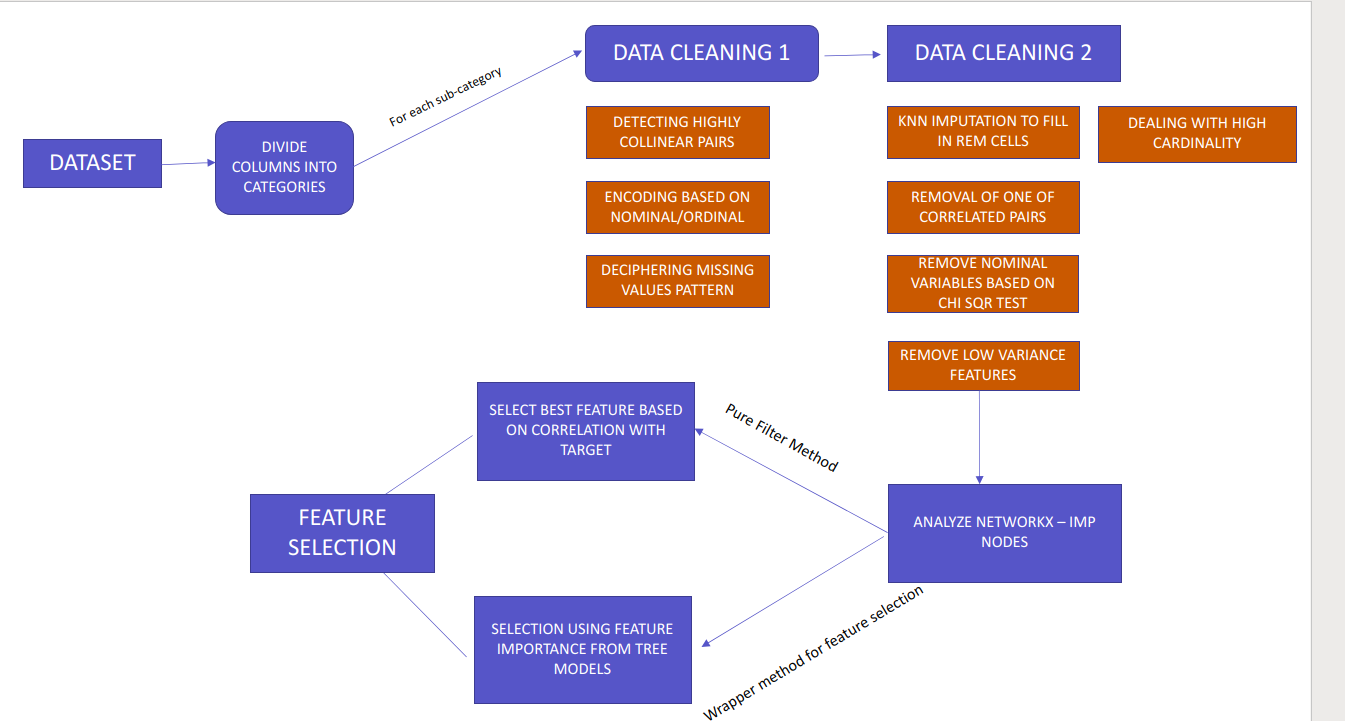

# Primary Data Cleaning

## Categorization of Columns 

I might create stray variables, but this list will only hold the actual features present in the dataset

Continous : uncountable/counting will take substantial time <br>
Categorical : countable in a finite amount of time <br>
Nominal Categorical : Those discrete variables which have no innate order or magnitude associated with them. <br>
Ordinal Categorical : Discrete variables that have a certain ranking. <br>
Other : Year,Month,Day,Id 

In [ ]:
#NUMERICAL COLUMNS/VARIABLES
num_vars = ['LotArea','LotFrontage','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF',
'1stFlrSF', '2ndFlrSF','WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
'LowQualFinSF', 'GrLivArea','GarageArea','SalePrice']

#ID COLUMN
id = ["Id"]

#YEAR COLUMNS
date = ["YearBuilt","YearRemodAdd","YrSold","MoSold"]
not_cat_vars = num_vars+id+date+["diff"]

#CLASSIFICATION COLUMNS
cat_vars = [col for col in df.columns.tolist() if col not in not_cat_vars]
ordinal_cat = ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType2','BsmtFinType1'
,'GarageQual','GarageCond','GarageCars','GarageFinish','PoolQC','HeatingQC','BsmtFullBath',
'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd']
nominal_cat = [col for col in cat_vars if col not in ordinal_cat]

#### INTERNAL VARIABLES 
#-----------> ROOMS, UTILITY, AREA, BASEMENT
Internal_vars = {}
Internal_vars['rooms'] = ['FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd']
Internal_vars['utility'] = ['Functional', 'Fireplaces', 'FireplaceQu','Heating','HeatingQC', 'CentralAir', 'Electrical','Utilities']
Internal_vars['area'] = ['LowQualFinSF', 'GrLivArea','1stFlrSF', '2ndFlrSF']
Internal_vars['basement'] = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath']


#### EXTERNAL VARIABLES
#-----------> EXTERIOR CONSTRUCTION, CONNECTIVITY, LOT, MAINTENANCE, POOL, ROOF
External_vars = {}
External_vars['dwelling'] = ['MSSubClass', 'MSZoning','BldgType','HouseStyle']
External_vars['exterior_cons'] = ['ExterQual','ExterCond','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','Foundation','Fence']
External_vars['lot'] = ['LotArea','LotShape','LandContour','LotConfig','LandSlope']
External_vars['connectivity'] = ['LotFrontage','Street','Alley','Neighborhood','Condition1','Condition2','PavedDrive']
External_vars['maintenance'] = ['OverallCond','OverallQual']
External_vars['pool'] = ['PoolArea', 'PoolQC']
External_vars['porch'] = ['WoodDeckSF', 'OpenPorchSF','EnclosedPorch','3SsnPorch', 'ScreenPorch']
External_vars['roof'] = ['RoofStyle', 'RoofMatl']

#### GARAGE VARIABLES
Garage = {}
Garage['garage'] = ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea', 'GarageQual','GarageCond']

#### SALE
#-----------> TYPE OF PROPERTY, ZONING, SALE TYPE, SALE PRICE
Sale = {}
Sale['sale'] = ['SaleType','SaleCondition', 'SalePrice']

#### DATE
Date = {}
Date['yearORmonth'] = ['YearBuilt', 'YearRemodAdd','YrSold','MoSold']

#### OTHER (Misc)
Other = {}
Other['misc'] = ['MiscFeature', 'MiscVal']

All_columns_dict = [Internal_vars,External_vars,Garage,Sale,Date,Other]
All_columns_name = ['Internal Variables','External Variables','Garage Variables', 'Sale related Variables','Date/Year/Monthh','Other']
print("--------------------------------------------------------------------")
print("                   Summary of the Categorization                    ")
print("--------------------------------------------------------------------")
print("Categorical Columns : {} \n Numerical Columns : {} \n Id,Year Columns: {}".format(len(cat_vars),len(num_vars),len(id)+len(date)))
print("Nominal Columns : {} & Ordinal Columns : {}".format(len(nominal_cat),len(ordinal_cat)))
print("Total Columns : {}".format(len(num_vars)+len(id)+len(date)+len(cat_vars)))
print("-------------------------------------------------------------------")
total = 0
lis=[]
for i,dictionary in enumerate(All_columns_dict):
    for key,columns in dictionary.items():
        total += len(columns)

print("Total Columns : {}".format(total+len(id)))

vals=[[],[],[]]
vals[0]= All_columns_name

col = [[key for key,name in All_columns_dict[i].items()] for i in range(len(All_columns_dict))]
for i in range(len(col)):
    col[i] = ', '.join(col[i])
vals[1] = col    
vals[2] = [len(All_columns_dict[i]) for i in range(len(All_columns_dict))]

trace = go.Table(header=dict(values=['Type','Sub categories','#Columns']),cells=dict(values=vals))
fig = go.Figure(data = trace)
fig.show(renderer='colab')

--------------------------------------------------------------------
                   Summary of the Categorization                    
--------------------------------------------------------------------
Categorical Columns : 58 
 Numerical Columns : 18 
 Id,Year Columns: 5
Nominal Columns : 36 & Ordinal Columns : 22
Total Columns : 81
-------------------------------------------------------------------
Total Columns : 81


In [ ]:
#Utility functions :

def encode_nominal_vars(df,column):
    '''
    Takes in a dataframe and the nominal categorical column
    Returns a dictionary mapping classes with values from label encoder
    Used for encoding nominal variables
    '''
    le = LabelEncoder()
    le = le.fit(df[column].values)
    encode = dict(zip(le.classes_, le.transform(le.classes_)))
    return encode


#Lists holding column names that have to be processed in secondary data cleaning

#Will hold column pairs as tuples that show significant linear correlation
highly_collinear=[]

#These hold columns that will not be imputed by only looking at sub categories
tobe_imputed_cols=[]

#These will hold those nominal categorical columns that have very rare (<9 observations) 
#corresponding to certain classes -> I'll usesee if anycone binning on these variables in Part 2
rare_classes_present = []


Observations [IMPORTANT]

---
This will be a general pattern that I'll be following throught the rest of the sub categories. However, there are minor variations depending upon certain cases, as I'll elaborate, because of which I decided to do this individually instead of one central function. 

1. First print value counts, number of missing and number of unique values in/for each column in the sub category. These sub categories are essentially a dictionary mapping to list of columns. 

2. I proceed to finding which columns have missing observations. Mostly the columns show similar number of missing observations, sharing index value (as confirmed in the .isna() heatmap above too). While, interpreting it, I learnt that most of them correspond to absence of a feature. For example, "GarageCond" and "GarageQual" is nan corresponding to "GarageArea"=0. This is also true for basement, porch, pool, etc. I replace np.nan with 0s in this case. 
3. If, however, the missing call cannot be interpreted this way, I let those nan values remain in the column and encode rest of the values. Any imputer can ideally be used but I decided to use KNNImputer (more about this later). This requires me to encode all columns so I store these column names to tobe_imputed_cols list, to be dealt with in secondary data cleaning. If no missing cells, I skip

4. Next, encoding. Using descriptions, I identify a discrete variable as either nominal or ordinal. For ordinal variables (all quality, condition and quantity variables), I create a dictionary mapping giving higher value to higher scores ("Ex"/"Excellent" > "Av"/"Average") or higher quantity (3 rooms above grade > 1). If no encoding requred, I skip.

6. For nominal variables, if the nan values are imputed using understanding like above, I use label encoder to encode the columns. I also maintain a dictionary mapping using encode_nominal_vars functions

7. Next, high collinearity. The idea here is to reduce the dimension of the dataset and remove redundant features. A high correlation means that the second feature is not explaining any additional variance in the target variable. I check this through Spearman correlation and store the pairs in highly_collinear list. 

8. Note that point(6) is ONLY done for ordinal and continous variables. To identify related discrete variables, I perform chi square test later. Here is where storing multiple lists - categorical, categorical and nominal,ordinal, etc is extremely useful!

9. Since I'm doing in place encoding, the cells will show KeyError if run again so do take note of that. Thanks

Why Spearman?

---
1. Pearson correlation evaluates the linear relationship between two continuous variables whereas Spearman correlation evaluates the monotonic relationship (which includes linear). 

The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data. This makes it useful for continous and ordinal variables and NOT for nominal (because they have no rank). I show a figure only if number of ordinal+continous columns in that sub category is atleast 2. 


## External Variables


### Dwelling



In [ ]:
print("Before Data Cleaning : \n")
for column in External_vars['dwelling']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#Encoding 
encoding_mszoning = encode_nominal_vars(df,'MSZoning')
df['MSZoning'] = df['MSZoning'].apply(lambda x : encoding_mszoning[x])

encoding_bldgtype = encode_nominal_vars(df,'BldgType')
df['BldgType'] = df['BldgType'].apply(lambda x : encoding_bldgtype[x])

encoding_housestyle = encode_nominal_vars(df,'HouseStyle')
df['HouseStyle'] = df['HouseStyle'].apply(lambda x : encoding_housestyle[x])


#Detecting  highly collinear pairs

#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['dwelling']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

Before Data Cleaning : 

MSSubClass | Missing/NaN : 0 | #Unique Values : 15
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


MSZoning | Missing/NaN : 0 | #Unique Values : 5
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


BldgType | Missing/NaN : 0 | #Unique Values : 5
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


HouseStyle | Missing/NaN : 0 | #Unique Values : 8
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64




### Porch

Before Data Cleaning : 

WoodDeckSF | Missing/NaN : 0 | #Unique Values : 274
0      761
192     38
100     36
144     33
120     31
      ... 
269      1
265      1
263      1
260      1
215      1
Name: WoodDeckSF, Length: 274, dtype: int64


OpenPorchSF | Missing/NaN : 0 | #Unique Values : 202
0      656
36      29
48      22
20      21
40      19
      ... 
159      1
156      1
148      1
142      1
119      1
Name: OpenPorchSF, Length: 202, dtype: int64


EnclosedPorch | Missing/NaN : 0 | #Unique Values : 120
0      1252
112      15
96        6
120       5
144       5
       ... 
174       1
177       1
183       1
189       1
552       1
Name: EnclosedPorch, Length: 120, dtype: int64


3SsnPorch | Missing/NaN : 0 | #Unique Values : 20
0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3Ss

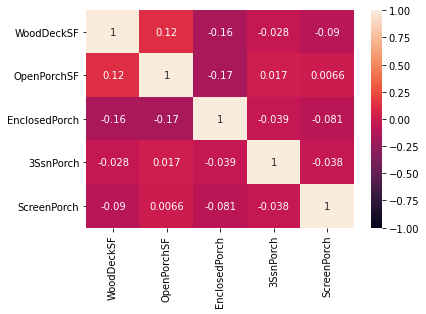

In [ ]:
print("Before Data Cleaning : \n")
for column in External_vars['porch']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#Detecting  highly collinear pairs

#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['porch']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

### Connectivity

In [ ]:
print("Before Data Cleaning : \n")
for column in External_vars['connectivity']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

tobe_imputed_cols.extend(['LotFrontage'])

# #encoding 

encoding_alley = {np.nan:0,'Grvl':1,'Pave':2}
df['Alley'] = df['Alley'].apply(lambda x : encoding_alley[x])

encoding_street = encode_nominal_vars(df,'Street')
df['Street'] = df['Street'].apply(lambda x : encoding_street[x])

encoding_neighborhood = encode_nominal_vars(df,'Neighborhood')
df['Neighborhood'] = df['Neighborhood'].apply(lambda x : encoding_neighborhood[x])

encoding_condition1 = encode_nominal_vars(df,'Condition1')
df['Condition1'] = df['Condition1'].apply(lambda x : encoding_condition1[x])

encoding_condition2 = encode_nominal_vars(df,'Condition2')
df['Condition2'] = df['Condition2'].apply(lambda x : encoding_condition2[x])

encoding_paveddrive = encode_nominal_vars(df,'PavedDrive')
df['PavedDrive'] = df['PavedDrive'].apply(lambda x : encoding_paveddrive[x])

#Detecting  highly collinear pairs

#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['connectivity']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)


Before Data Cleaning : 

LotFrontage | Missing/NaN : 259 | #Unique Values : 110
NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 111, dtype: int64


Street | Missing/NaN : 0 | #Unique Values : 2
Pave    1454
Grvl       6
Name: Street, dtype: int64


Alley | Missing/NaN : 1369 | #Unique Values : 2
NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64


Neighborhood | Missing/NaN : 0 | #Unique Values : 25
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


Condition1 | Missing/NaN : 0 | #Unique Values : 9
N

1. The nan values in "Alley" very obviously mean absence of an alley.
2. Neighbourhood, Conditon1, Conditon2 contain rare classes

### Exterior

Prior to cleaning ....
ExterQual | Missing/NaN : 0 | #Unique Values : 4
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64


ExterCond | Missing/NaN : 0 | #Unique Values : 5
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


Exterior1st | Missing/NaN : 0 | #Unique Values : 15
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64


Exterior2nd | Missing/NaN : 0 | #Unique Values : 16
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64


MasVnrType | Missing/NaN : 8 | #Unique Values : 4
None       864
BrkFace    445
Sto

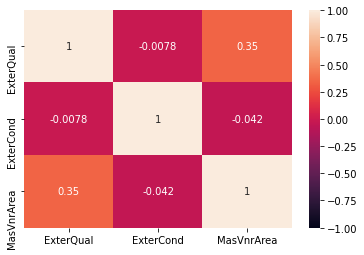

In [ ]:
print("Prior to cleaning ....")
for column in External_vars['exterior_cons']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

encoding_masvnrtype = {np.nan:np.nan, 'BrkCmn':1, 'BrkFace':2, 'None':3, 'Stone':4}
df['MasVnrType'] = df['MasVnrType'].apply(lambda x : encoding_masvnrtype[x])
tobe_imputed_cols.extend(['MasVnrArea','MasVnrType'])

#encoding 
encoding_exterior1st = encode_nominal_vars(df,'Exterior1st')
df['Exterior1st'] = df['Exterior1st'].apply(lambda x : encoding_exterior1st[x])

encoding_exterior2nd = encode_nominal_vars(df,'Exterior2nd')
df['Exterior2nd'] = df['Exterior2nd'].apply(lambda x : encoding_exterior2nd[x])

encoding_foundation = encode_nominal_vars(df,'Foundation')
df['Foundation'] = df['Foundation'].apply(lambda x : encoding_foundation[x])

encoding_extrquality = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
df['ExterQual'] = df['ExterQual'].apply(lambda x : encoding_extrquality[x])

encoding_extrcondition = {'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
df['ExterCond'] = df['ExterCond'].apply(lambda x : encoding_extrcondition[x])

encoding_fence = {np.nan:0,'MnPrv':1,'GdPrv':2,'GdWo':3,'MnWw':4}
df['Fence'] = df['Fence'].apply(lambda x : encoding_fence[x])

#Detecting  highly collinear pairs

#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['exterior_cons']]
if len(External_vars['exterior_cons'])>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)


1. No highly collinear pair present
2. An absense of a MasVnrType (nan) suggests absense of masonry veneer => corresponfing MasVnrArea = 0
3. Exterior1st,2nd has high cardinality

### Lot

In [ ]:
print("Prior to cleaning ....")

for column in External_vars['lot']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

encoding_lotshape = {'Reg':0,'IR1':1,'IR2':3,'IR3':4}
df['LotShape'] = df['LotShape'].apply(lambda x : encoding_lotshape[x])

encoding_landcontour = {'Lvl':0,'Bnk':1,'HLS':2,'Low':3}
df['LandContour'] = df['LandContour'].apply(lambda x : encoding_landcontour[x])

encoding_lotconfig = {'Inside':1,'Corner':2,'CulDSac':3,'FR2':4,'FR3':5}
df['LotConfig'] = df['LotConfig'].apply(lambda x : encoding_lotconfig[x])

encoding_landslope = {'Gtl':1,'Mod':2,'Sev':3}
df['LandSlope'] = df['LandSlope'].apply(lambda x : encoding_landslope[x])

#Detecting highly collinear pairs
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['lot']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)


highly_collinear.append(('LandSlope','LandContour'))


Prior to cleaning ....
LotArea | Missing/NaN : 0 | #Unique Values : 1073
7200     25
9600     24
6000     17
10800    14
9000     14
         ..
7094      1
6130      1
9337      1
5232      1
8190      1
Name: LotArea, Length: 1073, dtype: int64


LotShape | Missing/NaN : 0 | #Unique Values : 4
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


LandContour | Missing/NaN : 0 | #Unique Values : 4
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


LotConfig | Missing/NaN : 0 | #Unique Values : 5
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


LandSlope | Missing/NaN : 0 | #Unique Values : 3
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64




### Maintenance

Prior to cleaning ....
OverallCond | Missing/NaN : 0 | #Unique Values : 9
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64


OverallQual | Missing/NaN : 0 | #Unique Values : 10
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


No Imputation or Encoding required!


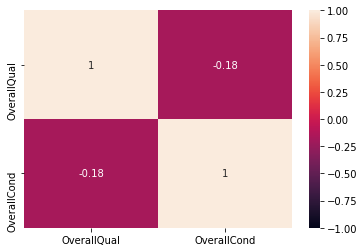

In [ ]:
print("Prior to cleaning ....")

for column in External_vars['maintenance']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

print("No Imputation or Encoding required!")

#Detecting highly collinear pairs
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['maintenance']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)


1. The statistical tests rely on a lot of assumptions and may not be 100% interpretable.

2. For example above, it is surprising to see a negative (albeit of low magnitude) value between overall condition and quality

3. Hence, I'm using this correlation as a high threshold filter only for selecting pairs showing SIGNIfICANT corr (>=0.8)

In [ ]:
#In order to confirm, I checked the observations
pd.crosstab(df['OverallCond'],df['OverallQual'])

OverallQual,1,2,3,4,5,6,7,8,9,10
OverallCond,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0
2,0,0,2,1,1,0,0,0,1,0
3,1,2,3,5,7,6,1,0,0,0
4,0,0,6,20,21,6,3,1,0,0
5,0,1,2,44,142,180,247,148,42,15
6,0,0,5,24,104,83,28,7,0,1
7,0,0,1,19,89,66,23,7,0,0
8,0,0,1,2,29,30,8,2,0,0
9,0,0,0,1,4,3,9,3,0,2


We can see how high OverallQual scores : 8,9,10 are concentrated at OverallCond=5 and decrease as the latter increases. This is perhaps why. The OverallCond doesn't seem to have enough variance as it is largely concentrated at 5. It would make sense to have a variable < or >=5 instead of this. Here, 5 may not correspond to the actual value but rather index

### Pool

In [ ]:

print("Prior to cleaning ....")
for column in External_vars['pool']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

encode_pool = {np.nan:0,'Fa':1,'Gd':2,'Ex':3}
df['PoolQC'] = df['PoolQC'].apply(lambda x : encode_pool[x])

print("Post cleaning ....")
for column in External_vars['pool']:
    print(column)
    print(df[column].value_counts(dropna=False))
    print('\n')


#Detecting highly collinear pairs
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['pool']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

highly_collinear.append(('PoolArea','PoolQC'))


Prior to cleaning ....
PoolArea | Missing/NaN : 0 | #Unique Values : 8
0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64


PoolQC | Missing/NaN : 1453 | #Unique Values : 3
NaN    1453
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64


Post cleaning ....
PoolArea
0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64


PoolQC
0    1453
2       3
3       2
1       2
Name: PoolQC, dtype: int64




1. It is clear that the NaN values in PoolQC actually correspond to No Pool (Pool area=0). We can replace NaN with a proxy for no pool. 

2. We can also see that PoolQC is a ordinal categorical variable. Hence, I'll encode it in a way to preserve this information. 

### Roof

In [ ]:

print("Prior to cleaning ....")
for column in External_vars['roof']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

encode_roofstyle = encode_nominal_vars(df,'RoofStyle')
df['RoofStyle'] = df['RoofStyle'].apply(lambda x : encode_roofstyle[x])

encode_roofmatl = encode_nominal_vars(df,'RoofMatl')
df['RoofMatl'] = df['RoofMatl'].apply(lambda x : encode_roofmatl[x])


#Detecting highly collinear pairs
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in External_vars['roof']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)


Prior to cleaning ....
RoofStyle | Missing/NaN : 0 | #Unique Values : 6
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


RoofMatl | Missing/NaN : 0 | #Unique Values : 8
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
Membran       1
Metal         1
ClyTile       1
Name: RoofMatl, dtype: int64




## Internal Variables

### Room


Before Data Cleaning : 

FullBath | Missing/NaN : 0 | #Unique Values : 4
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64


HalfBath | Missing/NaN : 0 | #Unique Values : 3
0    913
1    535
2     12
Name: HalfBath, dtype: int64


BedroomAbvGr | Missing/NaN : 0 | #Unique Values : 8
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64


KitchenAbvGr | Missing/NaN : 0 | #Unique Values : 4
1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64


KitchenQual | Missing/NaN : 0 | #Unique Values : 4
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


TotRmsAbvGrd | Missing/NaN : 0 | #Unique Values : 12
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64




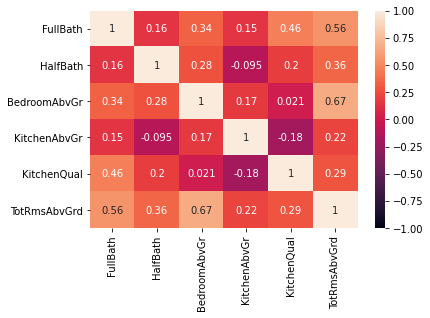

In [ ]:
print("Before Data Cleaning : \n")
for column in Internal_vars['rooms']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')


#encoding - ORDINAL 
encoding_kitchenqual = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
df['KitchenQual'] = df['KitchenQual'].apply(lambda x : encoding_kitchenqual[x])

#Detecting  highly collinear pairs
#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Internal_vars['rooms']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)



### Utility

In [ ]:
print("Before Data Cleaning : \n")
for column in Internal_vars['utility']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#encoding 
encoding_fireplacequ = {np.nan:0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df['FireplaceQu'] = df['FireplaceQu'].apply(lambda x : encoding_fireplacequ[x])

encoding_functional = encode_nominal_vars(df,'Functional')
df['Functional'] = df['Functional'].apply(lambda x : encoding_functional[x])

encoding_heating = encode_nominal_vars(df,'Heating')
df['Heating'] = df['Heating'].apply(lambda x : encoding_heating[x])

encoding_heatingqc = {np.nan:0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df['HeatingQC'] = df['HeatingQC'].apply(lambda x : encoding_heatingqc[x])

encoding_centralair = encode_nominal_vars(df,'CentralAir')
df['CentralAir'] = df['CentralAir'].apply(lambda x : encoding_centralair[x])

encoding_electrical = {np.nan:0,'FuseA':1,'FuseF':2,'FuseP':3,'Mix':4,'SBrkr':5}
df['Electrical'] = df['Electrical'].apply(lambda x : encoding_electrical[x])
tobe_imputed_cols.extend(['Electrical'])

encoding_utilities = encode_nominal_vars(df,'Utilities')
df['Utilities'] = df['Utilities'].apply(lambda x : encoding_utilities[x])

#Detecting  highly collinear pairs
#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Internal_vars['utility']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)


Before Data Cleaning : 

Functional | Missing/NaN : 0 | #Unique Values : 7
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


Fireplaces | Missing/NaN : 0 | #Unique Values : 4
0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64


FireplaceQu | Missing/NaN : 690 | #Unique Values : 5
NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64


Heating | Missing/NaN : 0 | #Unique Values : 6
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


HeatingQC | Missing/NaN : 0 | #Unique Values : 5
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


CentralAir | Missing/NaN : 0 | #Unique Values : 2
Y    1365
N      95
Name: CentralAir, dtype: int64


Electrical | Missing/NaN : 1 | #Unique Values : 5
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1


### Area 

Before Data Cleaning : 

LowQualFinSF | Missing/NaN : 0 | #Unique Values : 24
0      1434
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64


GrLivArea | Missing/NaN : 0 | #Unique Values : 861
864     22
1040    14
894     11
848     10
1456    10
        ..
3447     1
1396     1
1395     1
1393     1
2054     1
Name: GrLivArea, Length: 861, dtype: int64


1stFlrSF | Missing/NaN : 0 | #Unique Values : 753
864     25
1040    16
912     14
848     12
894     12
        ..
1285     1
1287     1
1288     1
1297     1
2053     1
Name: 1stFlrSF, Length: 753, dtype: int64


2ndFlrSF | Missing/NaN : 0 | #Unique Values : 417
0       829
728      10
504       9
672       8
546       8
       ... 
788       1
1116      1
1112      1
1111     

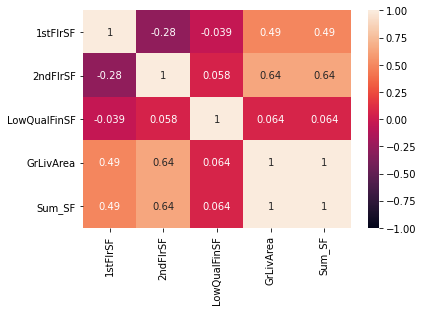

In [ ]:
print("Before Data Cleaning : \n")
for column in Internal_vars['area']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#Detecting  highly collinear pairs
#Continous and Ordinal
df['Sum_SF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['LowQualFinSF']
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Internal_vars['area']]
spearman_corr_cols.append('Sum_SF')
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

highly_collinear.append(('GrLivArea','Sum_SF'))

1. After going through descriptions and distributions from the first section, it seemed to me that GrLivArea is sum of the square feet area of 2 floors + unfinished square feet. It is confirmed in the above correlation matrix "Sum_SF" variable represents the sum. 

2. Feature engg idea : Combining area variables (for porch,basement,etc separately)

### Basement

Before Data Cleaning : 

BsmtQual | Missing/NaN : 37 | #Unique Values : 4
TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64


BsmtCond | Missing/NaN : 37 | #Unique Values : 4
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64


BsmtExposure | Missing/NaN : 38 | #Unique Values : 4
No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64


BsmtFinType1 | Missing/NaN : 37 | #Unique Values : 6
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NaN     37
Name: BsmtFinType1, dtype: int64


BsmtFinSF1 | Missing/NaN : 0 | #Unique Values : 637
0       467
24       12
16        9
20        5
686       5
       ... 
1032      1
1022      1
599       1
1018      1
1904      1
Name: BsmtFinSF1, Length: 637, dtype: int64


BsmtFinType2 | Missing/NaN : 38 | #Unique Values : 6
Unf    1256
Rec      54
LwQ      46
NaN      38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype

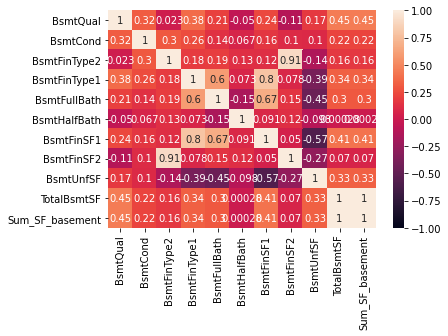

In [ ]:
print("Before Data Cleaning : \n")
for column in Internal_vars['basement']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#encoding 
encoding_bsmtqual = {np.nan:0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df['BsmtQual'] = df['BsmtQual'].apply(lambda x : encoding_bsmtqual[x])

encoding_bsmtcond = {np.nan:0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df['BsmtCond'] = df['BsmtCond'].apply(lambda x : encoding_bsmtcond[x])

encoding_bsmtfintype1 = {np.nan:0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda x : encoding_bsmtfintype1[x])

index = df['BsmtCond'].loc[df['BsmtCond'].isin([0])].index.tolist()
df.loc[index,'BsmtExposure'] = 0
df.loc[index,'BsmtFinType2'] = 0
encoding_bsmtexposure = {np.nan:np.nan,0:0,'No':1,'Mn':1,'Av':2,'Gd':3}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x : encoding_bsmtexposure[x])

encoding_bsmtfintype2 = {np.nan:np.nan,0:0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda x : encoding_bsmtfintype2[x])

tobe_imputed_cols.extend(['BsmtExposure','BsmtFinType2'])

#Detecting  highly collinear pairs
#Continous and Ordinal
df['Sum_SF_basement'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Internal_vars['basement']]
spearman_corr_cols.append('Sum_SF_basement')
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

highly_collinear.append(('BsmtFinSF1','BsmtFinType1'))
highly_collinear.append(('BsmtFinSF2','BsmtFinType2'))

Here, I can see how BsmtFinType1 shows 37 missing values while BsmtFinType2 shows 38. The 37 rows overlap and hence, I take that as absence of basement. However,the one row still needs to be imputed and hence I store the column.

## Garage

Prior to cleaning ....

GarageType | Missing/NaN : 81 | #Unique Values : 6
Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64


GarageYrBlt | Missing/NaN : 81 | #Unique Values : 97
NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
          ..
1906.0     1
1927.0     1
1900.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 98, dtype: int64


GarageFinish | Missing/NaN : 81 | #Unique Values : 3
Unf    605
RFn    422
Fin    352
NaN     81
Name: GarageFinish, dtype: int64


GarageCars | Missing/NaN : 0 | #Unique Values : 5
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64


GarageArea | Missing/NaN : 0 | #Unique Values : 441
0       81
440     49
576     47
240     38
484     34
        ..
754      1
459      1
458      1
756      1
1418     1
Name: GarageArea, Length: 441, dtype: int64


GarageQual | Missing/NaN : 81 | #Unique Values : 5
TA     1311
NaN

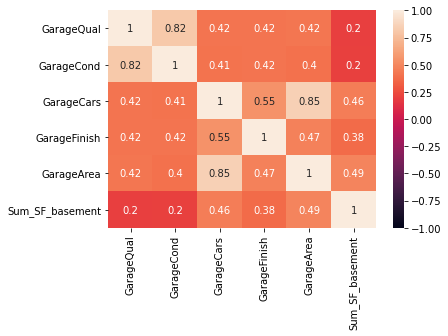

In [ ]:
print("Prior to cleaning ....\n")

for column in Garage['garage']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#encoding 
index = df.loc[df['GarageType'].isna()].index
df.loc[index,'GarageType'] = 'No Garage'
encoding_garagetype = encode_nominal_vars(df,'GarageType')
df['GarageType'] = df['GarageType'].apply(lambda x : encoding_garagetype[x])

encoding_garagefinish = {np.nan:0,'Unf':1,'RFn':2,'Fin':3}
df['GarageFinish'] = df['GarageFinish'].apply(lambda x : encoding_garagefinish[x])

encoding_garagequal = {np.nan:0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df['GarageQual'] = df['GarageQual'].apply(lambda x : encoding_garagequal[x])

encoding_garagecond = {np.nan:0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
df['GarageCond'] = df['GarageCond'].apply(lambda x : encoding_garagecond[x])

indices = df.loc[df['GarageYrBlt'].isna()].index.tolist()
for index in indices:
    df.loc[index,'GarageYrBlt'] = df['YearBuilt'].iloc[index]

#Detecting  highly collinear pairs
#Continous and Ordinal
df['Sum_SF_basement'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Garage['garage']]
spearman_corr_cols.append('Sum_SF_basement')
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

highly_collinear.append(('GarageQual','GarageCond'))



## Sale

In [ ]:
print("Prior to cleaning ....\n")

for column in Sale['sale']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#encoding
encoding_saletype = encode_nominal_vars(df,'SaleType')
df['SaleType'] = df['SaleType'].apply(lambda x : encoding_saletype[x])

encoding_salecond = encode_nominal_vars(df,'SaleCondition')
df['SaleCondition'] = df['SaleCondition'].apply(lambda x : encoding_salecond[x])


#Detecting  highly collinear pairs
#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Sale['sale']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)



Prior to cleaning ....

SaleType | Missing/NaN : 0 | #Unique Values : 9
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64


SaleCondition | Missing/NaN : 0 | #Unique Values : 6
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


SalePrice | Missing/NaN : 0 | #Unique Values : 663
140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64




## Date

In [ ]:
print("Prior to cleaning ....\n")

for column in Date['yearORmonth']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

#Detecting  highly collinear pairs
#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Date['yearORmonth']]
if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)

Prior to cleaning ....

YearBuilt | Missing/NaN : 0 | #Unique Values : 112
2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1906     1
1911     1
1913     1
1917     1
1872     1
Name: YearBuilt, Length: 112, dtype: int64


YearRemodAdd | Missing/NaN : 0 | #Unique Values : 61
1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1952      5
1986      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64


YrSold | Missing/NaN : 0 | #Unique Values : 5
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64


MoSold | Missing/NaN : 0 | #Unique Values : 12
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64




In [ ]:
#Understanding Sale Price with years

saleprice_year = df[[date[0],"SalePrice"]].groupby(by=date[0]).sum()
saleprice_year["Max_SalePrice"] = df[[date[0],"SalePrice"]].groupby(by=date[0]).max()
saleprice_year["Mean_SalePrice"] = df[[date[0],"SalePrice"]].groupby(by=date[0]).mean()
df["diff"] = df[date[0]] != date[1]
remodel = df[[date[0],"diff"]].groupby(by=date[0]).sum()

fig = subplots.make_subplots(rows=4, cols=1, shared_xaxes=False,shared_yaxes=False,
                            horizontal_spacing = 0.02)      
fig.add_trace(go.Scatter(
    name="Total SalePrice vs Year Built",
    mode="markers+lines", x=saleprice_year.index, y=saleprice_year["SalePrice"]),row=1,col=1
    )

fig.add_trace(go.Scatter(
    name="Maximum SalePrice vs Year Built",
    mode="markers+lines", x=saleprice_year.index, y=saleprice_year["Max_SalePrice"]),row=2,col=1
    )
fig.add_trace(go.Scatter(
    name="Mean SalePrice vs Year Build",
    mode="markers+lines",x=saleprice_year.index, y=saleprice_year["Mean_SalePrice"]),row=2,col=1
    )

fig.add_trace(go.Bar(
    name="Frequency of Remodelling vs Year",
    x=remodel.index, y=remodel["diff"]),row=3,col=1
    )

fig.add_trace(go.Scatter(
    name="SalePrice vs Year Sold",
    mode="markers",x=df[date[2]], y=df["SalePrice"]),row=4,col=1
    )

fig.update_xaxes(title_text="Year Built", type="linear",range=[1870,2010],row=1, col=1)
fig.update_xaxes(title_text="Year Built", type="linear",range=[1870,2010],row=2, col=1)
fig.update_xaxes(title_text="Year Remodelled", range=[1870,2010], row=3, col=1)
fig.update_xaxes(title_text="Year Sold",range=[2005,2011], row=4, col=1)

fig.update_yaxes(title_text="Sale Price", row=1, col=1)
fig.update_yaxes(title_text="Sale Price", row=2, col=1)
fig.update_yaxes(title_text="Sale Price", row=4, col=1)
fig.update_yaxes(title_text="Frequency of Remodelled", range=[0,180], row=3, col=1,showgrid=True)

fig.update_layout(title_text="Understanding Sale Price over years", height=1000)

fig.show(renderer="colab")

Observations

---


1. We can observe that variation in median Sale Price value over both years in which the houses were built and years when they were sold, is low. 

2. The mean SalePrice over Year Sold also has no distinct increasing or decreasing trend. 

3. We can observe that the mean SalePrice is higher for houses that are more recently built, although the trend is slow and picked up momentum in 2000s

2. Note the total sale price fluctuations for houses built in a particular year. These fluctuations increase for newer houses although the trend in mean is slower. This could mean higher maximum prices for certain houses built in a particular year. The spike at 2005-2006 in figure 2 corresponds to the pre housing crisis era. 

3. We can also contrast this against the total remodellings done in a particular year. From figure 2 and 3, we can observe that the period of higher Sale Prices corresponds to higher overall remodellings done.  

4. Since YearBuilt seems to have some impact on saleprices, we can consider it as an ordinal discrete variable denoting age of house

7. YearRemodAdd was transformed to show the count of remodellings done in that year. It can also be a feature engineering idea to consider.

Note that the number of years over which the data is collected is small and it shouldn't be interpreted as a numerical variable. Hence, I encode it : 1872:0 to 2011:1

In [ ]:
#encoding
years = np.arange(1872,2012)
codes = np.arange(1,2012-1872)
dict_year = dict(zip(years,codes))
inv_dict_year = {v: k for k, v in dict_year.items()}
df['YearBuilt'] = df['YearBuilt'].apply(lambda x : dict_year[x])
df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x : dict_year[x])
df['YearRemodAdd'] = df['YearRemodAdd'].apply(lambda x :dict_year[x])  
df['YrSold'] = df['YrSold'].apply(lambda x : dict_year[x])

## Other

In [ ]:
print("Prior to cleaning ....\n")

for column in Other['misc']:
    missing = "| Missing/NaN : " + str(np.sum(df[column].isna()))
    unique = "| #Unique Values : " + str(df[column].nunique())
    print(column,missing,unique)
    print(df[column].value_counts(dropna=False))
    print('\n')

index = df.loc[df['MiscFeature'].isna()].index
df.loc[index,'MiscFeature'] = 'No misc'
encoding_miscfeature = encode_nominal_vars(df,'MiscFeature')
df['MiscFeature'] = df['MiscFeature'].apply(lambda x : encoding_miscfeature[x])

#Detecting  highly collinear pairs
#Continous and Ordinal
spearman_corr_cols = ordinal_cat + num_vars
spearman_corr_cols = [col for col in spearman_corr_cols if col in Other['misc']]

if len(spearman_corr_cols)>1:
    sns.heatmap(df[spearman_corr_cols].corr(method = 'spearman'),annot=True,vmax=1,vmin=-1)



Prior to cleaning ....

MiscFeature | Missing/NaN : 1406 | #Unique Values : 4
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64


MiscVal | Missing/NaN : 0 | #Unique Values : 21
0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64




# Secondary Data Cleaning/Redundant Feature Removal 



## Imputation

KNN Imputation?

---
1. Mean,Median,Mode imputers only consider that particular column. Instead, using KNN here means, we find the house most similar the row with missing value and impute using it's column values. 

2. I make a dictionary to store missing row indices for every column that is yet to be imputed. I take a data subset for the remaining columns.

3. For each of the houses that need imputation, I find the most similar house using KNN where neighbors=1. This similarity is calculated based on euclidean distance between the remaining ordinal + continous features. Note, that I perform scaling before this because it's based on distance.




Remaining columns to be imputed : 
['BsmtFinType2', 'Electrical', 'BsmtExposure', 'LotFrontage', 'MasVnrArea', 'MasVnrType']


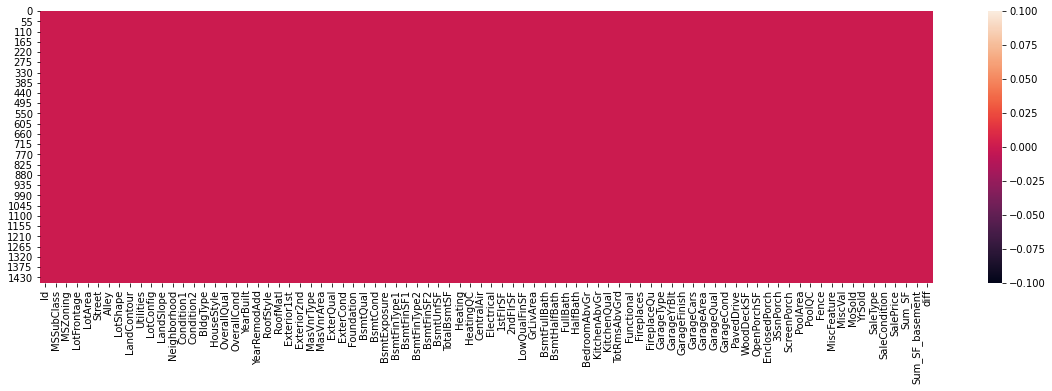

In [ ]:
print("Remaining columns to be imputed : ")
tobe_imputed_cols = list(set(tobe_imputed_cols))
print(tobe_imputed_cols)

df2 = df.dropna(axis=1,how='any').copy()
for column in num_vars:
    if column not in tobe_imputed_cols:
        scaler=StandardScaler()
        df2[column] = scaler.fit_transform(df2[column].values.reshape(-1,1))

covariates = [col for col in num_vars+ordinal_cat if col not in tobe_imputed_cols and col not in ['Id']]
missing_rows = np.where(df.isnull())[0]

dict_col2index_missing = {}
for col in tobe_imputed_cols:
    dict_col2index_missing[col] = df.loc[df[col].isna()].index.tolist()

def NNImputation(df2,tobe_imputed_cols):
    dict_col2closest_index = {}
    for column in tobe_imputed_cols:
        indices_missing = dict_col2index_missing[column]
        dict_col2closest_index[column] = []
        for index in indices_missing:
            base_vector = df2[covariates].iloc[index]
            distances = np.sqrt(np.sum((df2[covariates].values - base_vector.values)**2 ,axis=1)).reshape(len(df2))
            distances = np.delete(distances,missing_rows)
            sorted_indices = np.argsort(distances)
            for i in sorted_indices:
                if not math.isnan(df.loc[i,column]): 
                    closest_index = i
                    break
            dict_col2closest_index[column].append(closest_index)
    return dict_col2closest_index

dict_col2closest_index = NNImputation(df2,tobe_imputed_cols)
for column in tobe_imputed_cols:
    indices_missing = dict_col2index_missing[column]
    indices_closest = dict_col2closest_index[column]
    assert len(indices_missing) == len(indices_closest)
    for index_missing,index_closest in zip(indices_missing,indices_closest):
        df.loc[index_missing,column] = df[column].iloc[index_closest]

plt.figure(figsize=(20,5))
sns.heatmap(df.isna())

Finally, I'm done with missing values! All columns have also been encoded and the encoded dictionaries are stored

## Removing High Multicollinearity

We had made a list of tuples of column names with high correlation. Here, we'll compare all their correlation with the target variable and preserve the one with the higher correlation with target. 

There are some cases where the difference is very low to firmly decide, which is why I use 2 correlation metrics to select from both. It is important because dropping columns (and hence losing information) definitely has an impact

Pairs showing High collinearity based on Spearman
---------------------------------

LandSlope LandContour
BsmtFinSF1 BsmtFinType1
PoolArea PoolQC
GrLivArea Sum_SF
BsmtFinSF2 BsmtFinType2
GarageQual GarageCond
---------------------------------

interval columns not set, guessing: ['SalePrice', 'PoolArea', 'PoolQC', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea', 'BsmtFinSF1', 'BsmtFinType1', 'LandSlope', 'LandContour', 'BsmtFinSF2', 'BsmtFinType2', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'TotalBsmtSF', 'BsmtUnfSF']


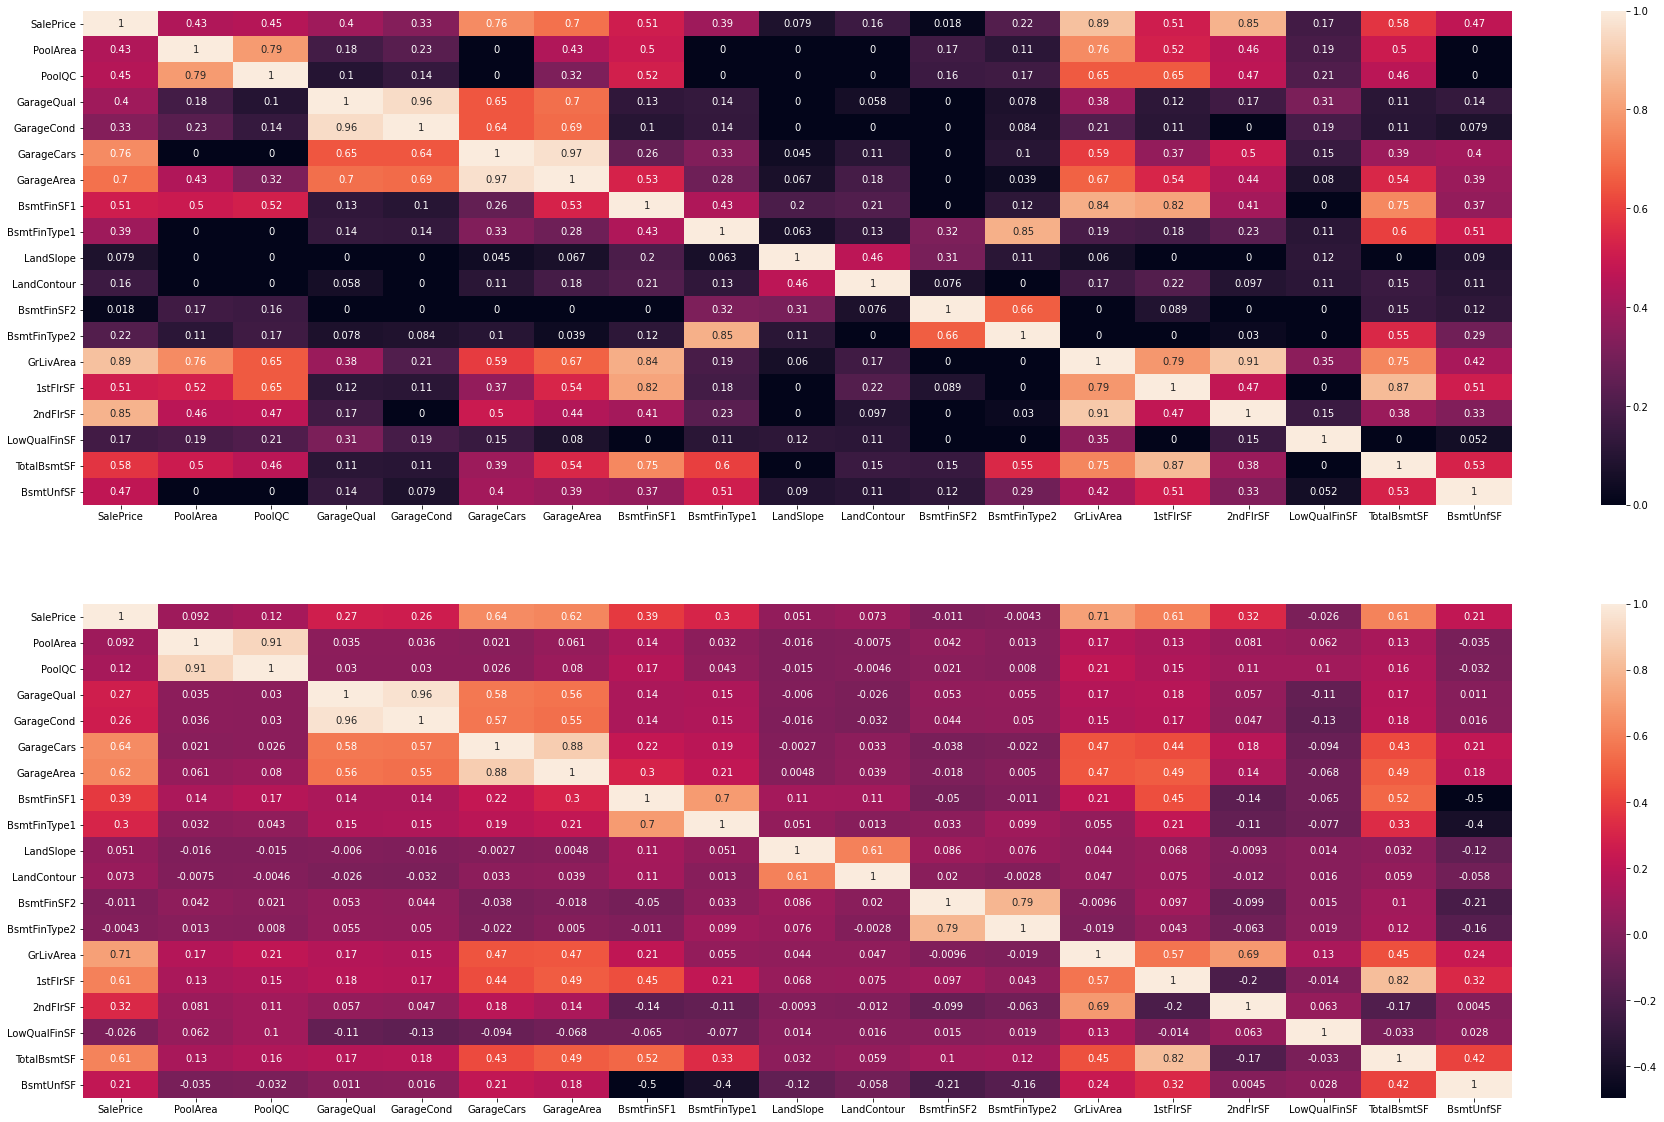

In [ ]:
print("Pairs showing High collinearity based on Spearman")
print('---------------------------------\n')
for pair1,pair2 in set(highly_collinear):
    print(pair1,pair2)
print('---------------------------------\n')

#List holding column names to be dropped
todrop= []

#Dropping the variable with lower correlation with target
vis = ['SalePrice','PoolArea', 'PoolQC','GarageQual','GarageCond','GarageCars','GarageArea','BsmtFinSF1','BsmtFinType1','LandSlope','LandContour','BsmtFinSF2','BsmtFinType2','GrLivArea','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','TotalBsmtSF','BsmtUnfSF']

#Phik 
corr1 = df[vis].phik_matrix()
#Spearman
corr2 = df[vis].corr()

plt.figure(figsize=(32,20))
plt.subplot(2,1,1)
sns.heatmap(corr1,annot=True)
plt.subplot(2,1,2)
sns.heatmap(corr2,annot=True)



In [ ]:
#For each pair, I drop the one with a lower avg corr with the target
for pair1,pair2 in set(highly_collinear):
    try:
        if (corr1['SalePrice'][pair1]+corr2['SalePrice'][pair1])/2 > (corr1['SalePrice'][pair2]+corr2['SalePrice'][pair2])/2:
            todrop.append(pair2)
        else:
            todrop.append(pair1)
    except:
        continue

I took note of the columns and will drop them at the end of this section

Chi square Test of Independece?

---
1. Chi-square test is a non-parametric (distribution-free) method used to compare the relationship between the two categorical (nominal) variables in a contingency table.

2. Null hypothesis: The two categorical variables are independent <br>
Alternative hypothesis: The two categorical variables are dependent 
Hence, if p value<alpha -> we reject null hypothesis

3. Assumptions : The expected frequency count should not be less than 1

As I've stored nominal categorical variables from the start, I go through them to calculate pairwise chi square statistic, p value etc. I check for assumption 3 and condition 2 and print the categorical variables having relation. 



In [ ]:

alpha = 0.01 #Confidence level
for i,col in enumerate(nominal_cat):
    for j,col2 in enumerate(nominal_cat):
        if col==col2 or j<=i:
            pass
        else:
            contingency = pd.crosstab(df[col],df[col2], margins = True)
            chi2, p, dof, ex = chi2_contingency(contingency,correction=True)
            if p < alpha and np.sum(ex<1)==0:
                print(col,col2)
                print("Chi square stat : {} , p value : {}, dof : {}".format(chi2,p,dof))
                print("----------------------")

#Adding the columns to be removed to todrop list
todrop.extend(['CentralAir'])

Alley CentralAir
Chi square stat : 60.971309706461504 , p value : 2.8568119235552266e-11, dof : 6
----------------------
LandContour CentralAir
Chi square stat : 27.011235424907593 , p value : 0.000703835194151845, dof : 8
----------------------
BldgType CentralAir
Chi square stat : 125.51992344627648 , p value : 3.8223460993577285e-22, dof : 10
----------------------
BsmtExposure CentralAir
Chi square stat : 70.65450585921161 , p value : 3.6401531109149464e-12, dof : 8
----------------------
CentralAir FireplaceQu
Chi square stat : 60.95857229637228 , p value : 1.5087381906315073e-08, dof : 12
----------------------
CentralAir PavedDrive
Chi square stat : 166.35932323473565 , p value : 2.6605877768858857e-33, dof : 6
----------------------


I'll remove CentralAir at the end of this section

## Variance Filter

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold ~quasi constant

### Continous

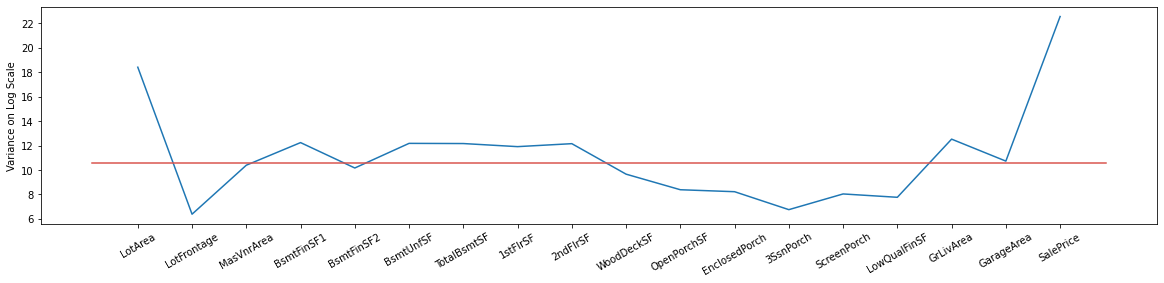

In [ ]:
vars = df[num_vars].var().values
cols = df[num_vars].var().index
plt.figure(figsize=(20,4))
g = sns.lineplot(y=np.log(vars),x=cols)
x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [np.log(np.median(vars))], sns.xkcd_rgb["pale red"])
plt.ylabel("Variance on Log Scale")
g.set_xticklabels(labels=cols,rotation=30)
plt.show()

#Adding the columns to be removed to todrop list
todrop.extend(['3SsnPorch'])

### Categorical

In [ ]:
sel = VarianceThreshold(threshold=0.05)
sel.fit(df[cat_vars])
lowvar_cols = [x for x in df[cat_vars].columns if x not in df[cat_vars].columns[sel.get_support()]]
print("Categorical Columns with 95% Same Values : ")
print(lowvar_cols)

#Adding the columns to be removed to todrop list
todrop.extend(lowvar_cols)

Categorical Columns with 95% Same Values : 
['Street', 'Utilities', 'KitchenAbvGr', 'PoolQC']


### Date/Year/Month

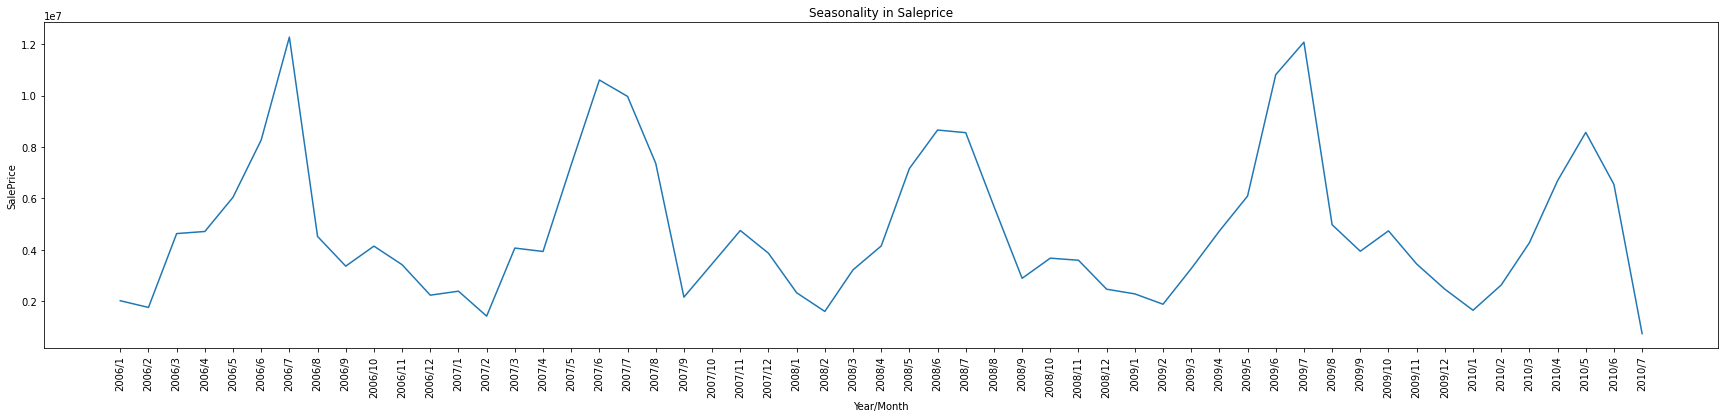

In [ ]:
#We can observe a seasonality in the data where there more number of sales in the month of July 

ym_df = df[['YrSold','MoSold','SalePrice']].groupby(["YrSold","MoSold"],as_index=False).sum()
xlabels = [str(inv_dict_year[ym_df['YrSold'].iloc[index]])+'/'+str(ym_df['MoSold'].iloc[index]) for index in ym_df.index.tolist()]


plt.figure(figsize=(30,6))
plt.plot(xlabels,ym_df['SalePrice'])
plt.title('Seasonality in Saleprice')
plt.xlabel('Year/Month')
plt.ylabel('SalePrice')
plt.xticks(rotation=90)
plt.show()

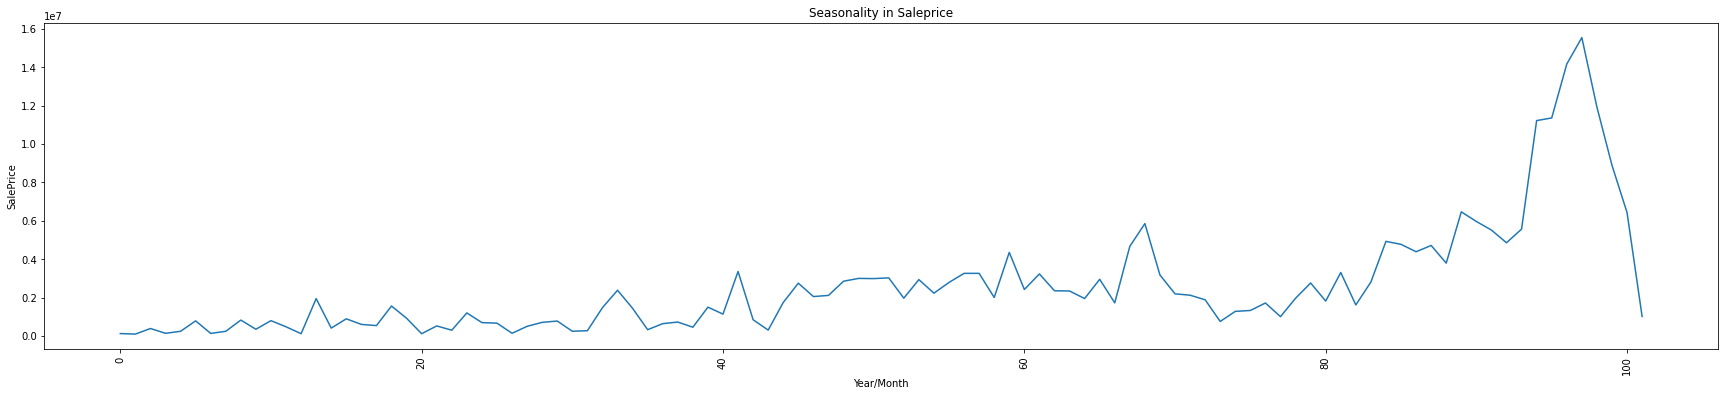

In [ ]:
#There is no distinct seasonality trend/relation with the GarageYrBlt. The shape also closely resembles YrBuilt, 
#which is why, I'll remove this feature
gy_df = df[['GarageYrBlt','SalePrice']].groupby(["GarageYrBlt"],as_index=False).sum()


plt.figure(figsize=(30,6))
plt.plot(gy_df['SalePrice'])
plt.title('Seasonality in Saleprice')
plt.xlabel('Year/Month')
plt.ylabel('SalePrice')
plt.xticks(rotation=90)
plt.show()

todrop.append('GarageYrBlt')

## High Cardinality

In [ ]:
highly_cardinal_features=[]
for column in cat_vars:
    if df[column].nunique()>10:
        highly_cardinal_features.append(column)

print("All {} labels with rare classes ".format(len(highly_cardinal_features)))
print(highly_cardinal_features)

All 7 labels with rare classes 
['MSSubClass', 'Neighborhood', 'Exterior1st', 'Exterior2nd', 'TotRmsAbvGrd', 'GarageYrBlt', 'MiscVal']


In [ ]:
def replace_rare_class(x,rare_class=[40],replacement=180):
    if x in rare_class:
        return replacement
    else:
        return x

### MSSubClass

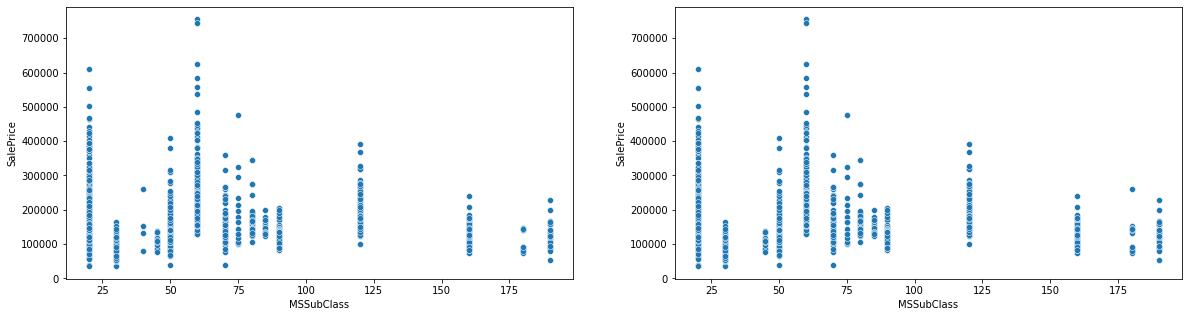

In [ ]:
#Joining the least frequent label with the second least frequent
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.scatterplot(x=df['MSSubClass'],y=df['SalePrice'])


df['MSSubClass'] = df['MSSubClass'].apply(replace_rare_class)
plt.subplot(1,2,2)
sns.scatterplot(x=df['MSSubClass'],y=df['SalePrice'])

### Neighborhood

Number of unique neighborhoods : 25


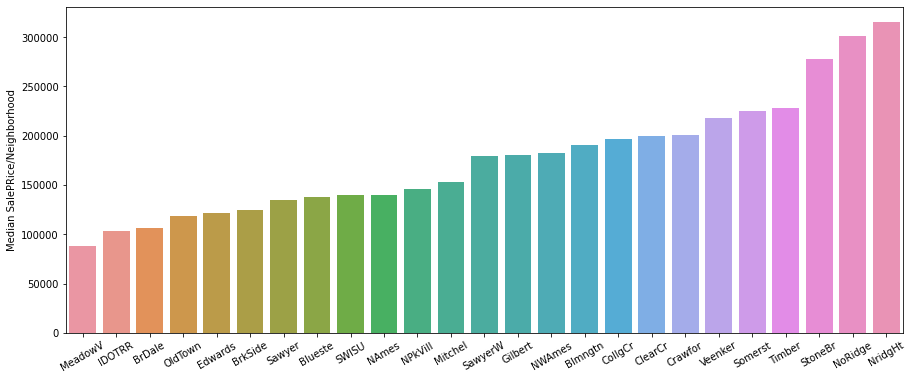

In [ ]:
#I am binning neighborhood based on quantiles. 


print("Number of unique neighborhoods : {}".format(df['Neighborhood'].nunique()))

inv_dict_neighborhood = {v: k for k, v in encoding_neighborhood.items()}

Neighborhood_binning = df[['Neighborhood','SalePrice']].groupby(['Neighborhood']).median()
Neighborhood_binning['Mean SalePrice'] = df[['Neighborhood','SalePrice']].groupby(['Neighborhood']).mean()
Neighborhood_binning = Neighborhood_binning.sort_values(['SalePrice','Mean SalePrice'])

plt.figure(figsize=(15,6))
xlabels = [inv_dict_neighborhood[encode] for encode in Neighborhood_binning.index.tolist()]
g = sns.barplot(x=xlabels,y=Neighborhood_binning['SalePrice'])
g.set_xticklabels(labels=xlabels,rotation=30)
plt.ylabel('Median SalePRice/Neighborhood')

plt.show()


In [ ]:
quant1 = np.quantile(Neighborhood_binning['SalePrice'],0.25)
quant3 = np.quantile(Neighborhood_binning['SalePrice'],0.75)

category1_neighborhoods = Neighborhood_binning.loc[Neighborhood_binning["SalePrice"]<quant1].index.tolist()
category2_neighborhoods = Neighborhood_binning.loc[(Neighborhood_binning["SalePrice"]>=quant1) & (Neighborhood_binning["SalePrice"]<=quant3)].index.tolist()
category3_neighborhoods = Neighborhood_binning.loc[Neighborhood_binning["SalePrice"]>quant3].index.tolist()

neighborhood_binned=[]
for i in range(len(df)):
    n = df['Neighborhood'].iloc[i]
    if n in category1_neighborhoods:
        neighborhood_binned.append(0)
    elif n in category2_neighborhoods:
        neighborhood_binned.append(1)
    elif n in category3_neighborhoods:
        neighborhood_binned.append(2)
        
df['Neighborhood'] = neighborhood_binned
print(df['Neighborhood'].value_counts())

1    841
0    341
2    278
Name: Neighborhood, dtype: int64


### Exterior1st and Exterior2nd

In [ ]:
#There are multiple labels with frequency 1. It is highly unlikely that test and train set can both represent
#such classes. Hence, I'm aggregating some levels by inspection of value counts
encoding_exterior1st['Other'] = 15
inv_dict_exterior1st = {v: k for k, v in encoding_exterior1st.items()}
inv_dict_exterior2nd = {v: k for k, v in encoding_exterior2nd.items()}

print("Value counts before combining rare classes ")
print(df['Exterior1st'].value_counts())
print(df['Exterior2nd'].value_counts())
print("\n")

df['Exterior1st'] = df['Exterior1st'].apply(lambda x: replace_rare_class(x,[10,2,7,4,1],encoding_exterior1st['Other']))
df['Exterior2nd'] = df['Exterior2nd'].apply(lambda x: replace_rare_class(x,[7,2,11,1,9,4],encoding_exterior2nd['Other']))

print("Value counts after combining rare classes ")
print(df['Exterior1st'].value_counts())
print(df['Exterior2nd'].value_counts())


count=0
for i in range(len(df)):
    if inv_dict_exterior1st[df['Exterior1st'].iloc[i]].lower() == inv_dict_exterior2nd[df['Exterior2nd'].iloc[i]].lower():
        count =count+1

print("Unique Values in Exterior1st + Exterior2nd : {}".format(df['Exterior1st'].nunique()+df['Exterior2nd'].nunique()))
print("% of houses where only one unique exterior material is present : {}".format(count/len(df)))

Value counts before combining rare classes 
12    515
6     222
8     220
13    206
9     108
5      61
3      50
14     26
11     25
0      20
10      2
2       2
7       1
4       1
1       1
Name: Exterior1st, dtype: int64
13    504
8     214
6     207
14    197
10    142
5      60
15     38
12     26
3      25
0      20
7      10
2       7
11      5
1       3
9       1
4       1
Name: Exterior2nd, dtype: int64


Value counts after combining rare classes 
12    515
6     222
8     220
13    206
9     108
5      61
3      50
14     26
11     25
0      20
15      7
Name: Exterior1st, dtype: int64
13    504
8     214
6     207
14    197
10    142
5      60
15     38
9      27
12     26
3      25
0      20
Name: Exterior2nd, dtype: int64
Unique Values in Exterior1st + Exterior2nd : 22
% of houses where only one unique exterior material is present : 0.8541095890410959


### TotRmsAbvGrd

In [ ]:
#Here.there is only one house with 14 rooms. Hence, I'm combining this with 12 rooms one to interpret as >=12 rooms
#There is only house with 2 rooms - I drop this row since it doesn't make sense to include with others

print("Value Counts before combining rare levels \n",df['TotRmsAbvGrd'].value_counts())
least_frequent = [14]
substituded_with = 12

df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'].apply(lambda x : replace_rare_class(x,least_frequent,substituded_with))

index_ = df.loc[df['TotRmsAbvGrd']==2].index.tolist()
df = df.drop(index_,axis=0)

print("Value Counts after combining >12 rooms \n",df['TotRmsAbvGrd'].value_counts())

Value Counts before combining rare levels 
 6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64
Value Counts after combining >12 rooms 
 6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     12
Name: TotRmsAbvGrd, dtype: int64


### MiscVal

In [ ]:
print("Value counts before combining rare levels")
print(df['MiscVal'].value_counts())
df['MiscVal'] = df['MiscVal'].apply(lambda x:int(x==0))
print("\nValue counts after : ")
print(df['MiscVal'].value_counts())

Value counts before combining rare levels
0        1407
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

Value counts after : 
1    1407
0      52
Name: MiscVal, dtype: int64


## Final Removal

In [ ]:
print("Columns to be dropped")
print('\n'.join(list(set(todrop))))

df.drop(list(set(todrop)),axis=1,inplace=True)
print("Current Shape of dataset : {}".format(df.shape))

Columns to be dropped
KitchenAbvGr
PoolQC
BsmtFinType1
BsmtFinSF2
GarageCond
LandSlope
CentralAir
PoolArea
Street
3SsnPorch
GarageYrBlt
Utilities
Current Shape of dataset : (1459, 72)


We have decreased the features to a more meaningful subset!

In [ ]:
#I update all the container-columns by removing the above todrop columns

def try_remove(list1,element):
    '''
    Given a List and an element, it attempts to remove that element
    from the list. If the list doesn't contain the element, instead of showing
    and error, this functions simply passes
    '''
    try:
        list1.remove(element)
    except:
        pass
    return list1

for col in todrop:
    num_vars = try_remove(num_vars,col)
    cat_vars = try_remove(cat_vars,col)
    ordinal_cat = try_remove(ordinal_cat,col)
    nominal_cat = try_remove(nominal_cat,col)

print("Storage columns have been updated ! ")

Storage columns have been updated ! 


In [ ]:
df1 = df.copy()
df = df1.copy()

# Feature Engg

## Year features


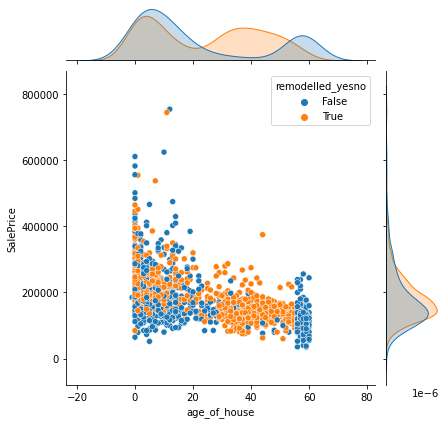

In [ ]:
#I create a variable which signifies whether remodelling took place
#and the age of the house

#As can be observed, an older house is negatively correlated with target
#However, as parts of old constructions will always remain and only parts of the house might have been renovated, 
#I will also introduce a Remodeled Yes/No variable.
new_catvars = ['remodelled_yesno']
new_numvars = ['age_of_house']

df['remodelled_yesno'] = df['YearBuilt'] == df['YearRemodAdd']
df['age_of_house'] = df['YrSold'] - df['YearRemodAdd']

sns.jointplot(x='age_of_house',y='SalePrice',data=df,hue='remodelled_yesno')

# Task 1

## Correlation Network

1. Note that Edge width is dependent on extent of correlation
2. Absence of node does not mean no correlation. 2 nodes can also be connected via a middle node

In [ ]:
def correlation_network(df, cols=num_vars,corr_thresh=0.6, data_type="Continous variables", node_color='#CCD4BF'):
    '''
    correlation threshold determines the threshold above which edge will be considered
    '''

    #Correlation matrix amongst the columns
    corr = df[cols].phik_matrix()
    corr = pd.melt(corr.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']

    # Filter only high correlations
    high_corr = corr[(corr['value'] >= corr_thresh)]
    high_corr = high_corr[(high_corr['value'] != 1)].reset_index(drop=True)
    
    #~~~~~~~~~~~~~~~~~
    #    The Graph
    #~~~~~~~~~~~~~~~~~
    
    sources = list(high_corr.x.unique())
    targets = list(high_corr.y.unique())
    

    plt.figure(figsize=(10, 10))
    g = nx.from_pandas_edgelist(high_corr, source='x', target='y') 
    layout = nx.spring_layout(g, iterations=50, k=0.6, seed=123)
    target_size = [g.degree(t) * 80 for t in targets]

    w = np.arange(0.5,5,4.5/len(target_size)).tolist()

    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist=targets, 
                           node_size=target_size, 
                           node_color=node_color)
    nx.draw_networkx_nodes(g, layout, nodelist=sources, node_color=node_color, node_size=800, alpha=0.5)

    nx.draw_networkx_edges(g, layout, width=w, edge_color="#E7CBA9")

    target_dict = dict(zip(targets, targets))
    nx.draw_networkx_labels(g, layout, labels=target_dict)

    plt.axis('off')
    plt.title(f"{data_type}: Highest Correlations Network", fontsize=25)
    plt.show();

### Continous variables 


interval columns not set, guessing: ['LotArea', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'SalePrice']


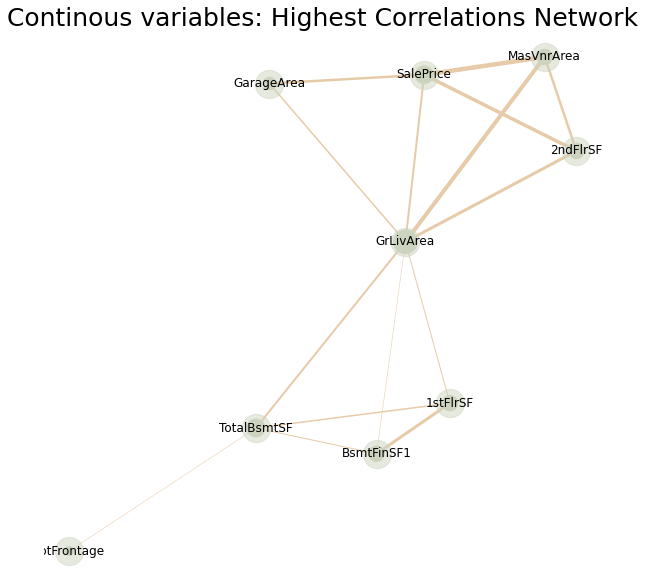

In [ ]:
threshold = 0.6 
correlation_network(df,num_vars,threshold)

Observations:

---
1. Since this task requires us to select a single variable - we can observe that "GrLivArea" is the winner for continous variables. Since phiK correlation captures both linear and non linear dependencies, we can safely assume that GrLivArea provides information about max no of multiple variables simultaneously and has substantial correlation with SalePrice.

2. Pool Area doesn't seem to impact sale price directly.


### Categorical Variables and SalePrice 

interval columns not set, guessing: ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType2', 'GarageQual', 'GarageCars', 'GarageFinish', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'SalePrice']


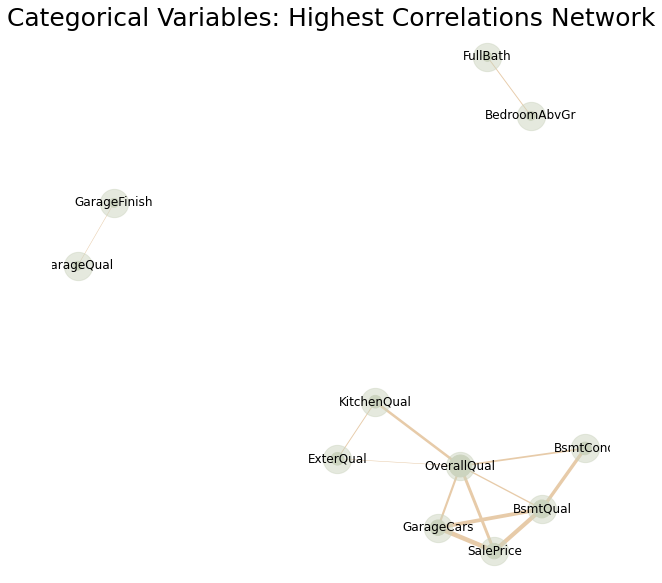

In [ ]:
threshold = 0.7 #Can be changed to higher threshold
correlation_network(df,cols=ordinal_cat+['SalePrice'],corr_thresh=threshold,data_type="Categorical Variables")

The 3 most important (wrt Target) relevant ordinal categorical variables:
1. GarageCars, BsmtQual and OverallQual. OverallQual is equivalent to GrLivArea in the above network as it has the max number of interconnections, providing info about other variables.

In [ ]:
#FINALLY : FOR THE SAKE OF CLARITY:
corr_cat = df[ordinal_cat+["SalePrice"]].corr(method='spearman')
corr_num = df[num_vars].phik_matrix()

print("------------------------Categorical (Ordinal) Columns-------------------------")
print("9 Most correlated Categorical Columns with SalePrice (spearman) : ")
print(corr_cat["SalePrice"].sort_values(ascending=False)[0:10])
ordinal_imp_cols = corr_cat["SalePrice"].sort_values(ascending=False)[0:10].index.tolist()

print("------------------------Continous Columns--------------------------------------")
print("9 Most correlated Continous Columns with SalePrice {spearman}: ")
print(corr_num["SalePrice"].sort_values(ascending=False)[0:10])
cont_imp_cols = corr_num["SalePrice"].sort_values(ascending=False)[0:10].index.tolist()


interval columns not set, guessing: ['LotArea', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'SalePrice']
------------------------Categorical (Ordinal) Columns-------------------------
9 Most correlated Categorical Columns with SalePrice (spearman) : 
SalePrice       1.000000
OverallQual     0.809428
GarageCars      0.690044
ExterQual       0.683282
BsmtQual        0.677328
KitchenQual     0.672132
FullBath        0.635591
GarageFinish    0.633211
TotRmsAbvGrd    0.531607
HeatingQC       0.490296
Name: SalePrice, dtype: float64
------------------------Continous Columns--------------------------------------
9 Most correlated Continous Columns with SalePrice {spearman}: 
SalePrice      1.000000
GrLivArea      0.885470
2ndFlrSF       0.854467
MasVnrArea     0.770093
GarageArea     0.699439
TotalBsmtSF    0.575632
1stFlrSF       0.519956


## Primary Task

Primary task:

1. We've observed that most of the Nominal Discrete value have labels between 2-15. While, this can possibly be crucial to understand direction of target, they cannot solely describe the large variation in target variable.

2. Amongst, nominal categorical variables, I shortlisted : 
'OverallQual','GarageCars','BsmtQual'. Since, they have ~0.6 correlation amongst themselves, we can only consider the top variable = 'OverallQual'. This makes sense as the convenient overall quality is marked from the perspective of having better potential in Sale price. 

3. Amongst continous variable, GrLivArea - which is Above grade living area. This also theoretically makes sense as houses with larger space for living are costlier. 

**Overall :
Most relevant feature = 'GrLivArea'**
Reasons, briefly (have been summarized above)
1. Higher range as compared to OverallQual
2. Strong increasing relationship with target (confirmed by scatterplot and correlation metrics)
3. Theoretical sense
4. High correlation with other features too (dependent)
5. And ofc wasn't lost in the eliminations I did

Note - Ideally, I wanted to check which of the final shortlisted variables was better at predicting the extremes in Sale Price data. This is because I noted huge fluctuations in max saleprice for every yeat. However we don't have data for enough years. 

## Visualization 

With the most important variables - from categorical and numerical

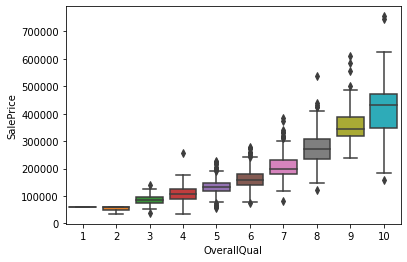

In [ ]:
sns.boxplot(data=df,x='OverallQual',y='SalePrice')

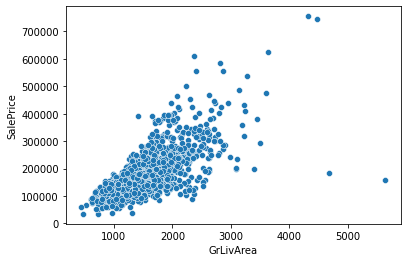

In [ ]:
sns.scatterplot(data=df,x='GrLivArea',y='SalePrice')

Observations [Outliers]:

---
1. House with Id=457 has a low overall quality and yet very high saleprice for the distribution. 

2. 2 Houses with Ids = 524,1299 show significant deviance in the second plot. Despite having a very large living area, the sale price seems to be too low. 

I can remove these outliers but it's usually not advisable to do so based on viz wrt to one variable. For example, the houses might be having large area but poor maintenance. I'll analyse this further in task 2 as outliers impact distance based models


In [ ]:
df = df.drop(index=[457,524,1299],axis=0)

## Feature Importance 

1. The above is without considering feature importance from models. There was some ambiguity with the PS - about whether it requires us to select feature purely based on EDA or we can use models as well. Hence, I am adding an extension to above and taking the liberty to continue. 

This can also be relevant for Task 2

2. The primary problem with Filter based methods is that they ignore feature interactions to a great extent.

3. This is improved in wrapper based feature selection methods which involves a greedy approach to measure the drop in score of a ML model because of n+1th feature addition,elimination or random permutation.

4. Moreover, in real modelling tasks, finding the best feature might not be more imp than finding the best subset. And the latter is best done in wrapper method. 


Wrapper methods like?

---





1. There is moderate cardinality amongst features so the below feature importance is calculated using Random Forest Feature Importance or <b>MDI</b> which is shared by most boosting regressors. 

2. This can also contrasted with <b>Permutation Feature Importance</b> which is calculated based on decrement in model score when the values in a feature are randomly shuffled. Although this method is better for high cardinality features, it might undervalue highly correlated features if they're present together - hence, preprocesisng pipeline should include removal of collinear features. 



In [ ]:

#Shuffling dataframe, train test split
df = df.sample(frac=1)
predictors = num_vars + cat_vars
predictors = [col for col in predictors if col not in ['Id','SalePrice']]
y = df['SalePrice'].values
X = df[predictors].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=12)

#Fitting model
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
print("Random Forest Model Fitted")
print(rf)


Random Forest Model Fitted
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


## Based on Gini Impurity

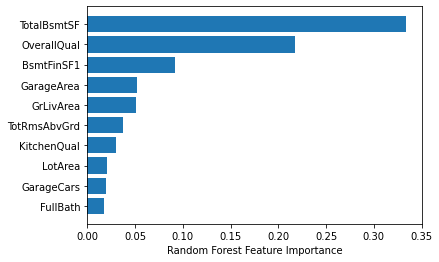

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
most_imp_rf_feats = []
for feat in sorted_idx:
    most_imp_rf_feats.append(predictors[feat])

plt.barh(most_imp_rf_feats[-10:], rf.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")

feat_imp = pd.DataFrame()
feat_imp['predictors_gini'] = predictors
feat_imp['feat_imp_rf'] = rf.feature_importances_
feat_imp = feat_imp.sort_values('feat_imp_rf')
#top 10 features
feats_imp_rf = feat_imp['predictors_gini'][-10:]

## Based on permutation importance


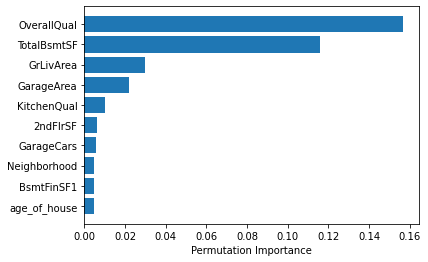

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
most_imp_rf_perm_feats = []
for feat in sorted_idx:
    most_imp_rf_perm_feats.append(predictors[feat])

plt.barh(most_imp_rf_perm_feats[-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")

feat_imp = pd.DataFrame()
feat_imp['predictors_perm'] = predictors
feat_imp['feat_imp_perm'] = rf.feature_importances_
feat_imp = feat_imp.sort_values('feat_imp_perm')
#Top 5 features
feats_imp_perm = feat_imp['predictors_perm'][-10:]

In [ ]:
#Features important through wrapper method
feat_imp_wrapper = list(set(feats_imp_perm.append(feats_imp_rf )))

#Arranged in descending order
feat_imp_wrapper = feat_imp_wrapper[::-1]

print("Most Important features using corr and feat importances are : ")
for feat in cont_imp_cols:
    if feat in feat_imp_wrapper:
        print(feat)

Most Important features using corr and feat importances are : 
GrLivArea
GarageArea
TotalBsmtSF
BsmtFinSF1



How to use feature importance along with correlation?


---
I took the top correlated numerical features. Amongst them, I compared the average feature importance score from the above method and got **GarageArea** as the most important feature. So the answer changes if we include wrapper method. 


# Task 2

## Data preprocessing

In [ ]:
date.remove('YrSold')
date.remove('YearRemodAdd')
date.remove('YearBuilt')
ordinal_cat.append('age_of_house')
nominal_cat.extend(['remodelled_yesno','MoSold'])
cat_vars = ordinal_cat + nominal_cat

continous_vars = {k:v for (k,v) in zip(num_vars,['float32']*len(num_vars))}
nominal_cat_vars = {k:v for (k,v) in zip(nominal_cat,['int32']*len(nominal_cat))}

#Changing datatype
df = df.astype(continous_vars)
df = df.astype(nominal_cat_vars)
df = df.astype({'age_of_house':'int32'})

print(df.dtypes)

Id                    int64
MSSubClass            int32
MSZoning              int32
LotFrontage         float32
LotArea             float32
                     ...   
Sum_SF                int64
Sum_SF_basement       int64
diff                   bool
remodelled_yesno      int32
age_of_house          int32
Length: 74, dtype: object


In [ ]:
df1 = df.copy()
df = df1.copy()

Skew
LotArea          12.382339
LotFrontage       1.900895
MasVnrArea        2.680426
BsmtFinSF1        1.689432
BsmtUnfSF         0.919487
TotalBsmtSF       1.541194
1stFlrSF          1.389348
2ndFlrSF          0.812275
WoodDeckSF        1.548350
OpenPorchSF       2.367198
EnclosedPorch     3.084454
ScreenPorch       4.115641
LowQualFinSF      8.998564
GrLivArea         1.379308
GarageArea        0.183619
SalePrice         1.895100
dtype: float32




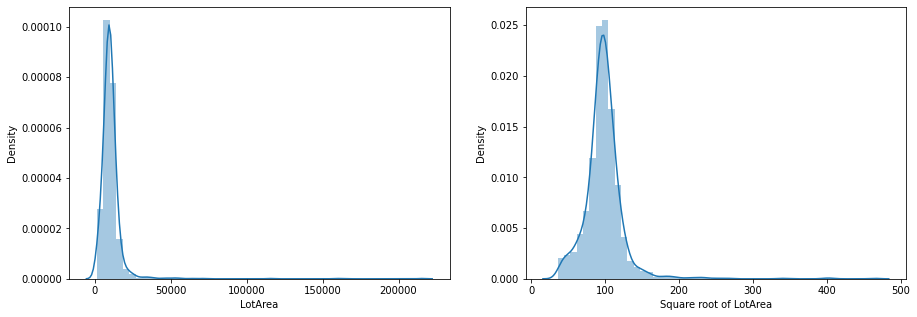


Skew
LotArea          4.170876
LotFrontage      1.900895
MasVnrArea       2.680426
BsmtFinSF1       1.689432
BsmtUnfSF        0.919487
TotalBsmtSF      1.541194
1stFlrSF         1.389348
2ndFlrSF         0.812275
WoodDeckSF       1.548350
OpenPorchSF      2.367198
EnclosedPorch    3.084454
ScreenPorch      4.115641
LowQualFinSF     8.998564
GrLivArea        1.379308
GarageArea       0.183619
SalePrice        1.895100
dtype: float32




In [ ]:
from scipy import stats

print("Skew")
print(df[num_vars].skew())
print("\n")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df["LotArea"])
plt.subplot(1,2,2)
sns.distplot(np.sqrt(df["LotArea"]),axlabel='Square root of LotArea')
plt.show()

df['LotArea'] = np.sqrt(df['LotArea'])

print("\nSkew")
print(df[num_vars].skew())
print("\n")


In [ ]:
#Converted nominal categorical variables into one hot encoding
#This is done because we don't want our model to misinterpret these as continous variables/ranked variables

df_hotencoded = pd.get_dummies(df[num_vars+cat_vars], columns = nominal_cat)
print("Final Shape of Dataset : ",df_hotencoded.shape)
df_hotencoded[num_vars].head()

Final Shape of Dataset :  (1456, 233)


,LotArea,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,LowQualFinSF,GrLivArea,GarageArea,SalePrice
86,109.137527,122.0,0.0,0.0,684.0,684.0,684.0,876.0,100.0,38.0,0.0,0.0,0.0,1560.0,400.0,174000.0
692,161.796173,42.0,293.0,965.0,245.0,1210.0,1238.0,1281.0,320.0,27.0,0.0,0.0,0.0,2519.0,628.0,335000.0
570,114.459602,74.0,108.0,231.0,1497.0,1728.0,1728.0,0.0,0.0,0.0,0.0,0.0,0.0,1728.0,576.0,142600.0
754,89.050545,61.0,0.0,439.0,115.0,1026.0,1026.0,0.0,171.0,48.0,0.0,0.0,0.0,1026.0,440.0,156000.0
917,130.919830,78.0,0.0,1059.0,75.0,1134.0,1229.0,0.0,0.0,0.0,0.0,0.0,0.0,1229.0,284.0,135000.0


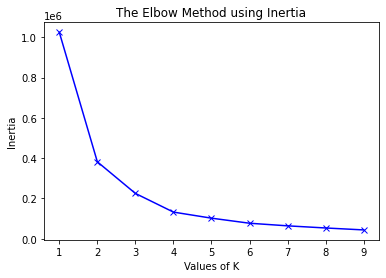

In [ ]:
# Here, I am visualizing inherent clusters in the dataset. This will help in answering the question about whether 
# a model is perfroming better on a "specific subset"
#Here subset corresponds to those houses belonging to distinct clusters
#Through elbow plot, I find the optimal K value
#Note that K means is sensitive to distance and hence, I apply scaling before

df_scaled = df.copy()
for column in num_vars:
    scaler=StandardScaler()
    df_scaled[column] = scaler.fit_transform(df_scaled[column].values.reshape(-1,1))


tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=5,random_state=123)
X = tsne.fit_transform(df_scaled[num_vars+ordinal_cat].drop(['SalePrice'],axis=1))
X = pd.DataFrame(data=X, columns=["tsne1","tsne2"], index=df.index)


K = range(1, 10)
inertias=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X.values)
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

gmm = KMeans(n_clusters=2)
clusters = pd.Series(gmm.fit_predict(X), index=df.index)
fig = px.scatter(x=X["tsne1"], 
                 y=X["tsne2"], 
                 color= clusters,
                 size_max=7)

fig.show(renderer='colab')

df['cluster'] = clusters

## Model Selection

Why XGBOOST? 

---
1. We have observed substantial skew and kurtosis in a few features in the dataset. Along with this, heteroskedasticity is also visible for the continous features. This means that linear models won't be very suitable to the problem statement. 

2. Boosting algorithms are efficient in avoiding overfitting, capturing non linear relations, not impacted by scale as much and can simultaneously handle many categorical as well as numerical variables

3. Xgboost belongs to decision tree based ensemble machine learning family and created by Tianqi Chen. Not like bagging ensemble method, all the trees are parallel, for Xgboost, all the trees are built sequentially. For each tree, the finally purpose is to reduce the residual error comparing previous tree. Hence, the tree that grows next in the sequence will learn from an updated version of the residuals. Hence, I prefer boosting over bagging. However, random forests are much simpler than xgboost so for quick analysis, they can be preferred as I did above. 

3. Amongst,the boosting algorithms XGBoost provides the ability to handle both ordinal encoded as well as one hot encoded variables. Catboost on the other hand, converts all categorical variables into one hot which means that we lose information about ranking in ordinal features. 

4. Xgboost also provides L1,L2 regularization parameters which is beneficial in a high dimension dataset such as this. 

## Feature Subset Selection

[13:17:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 0, 'Xgboost Feature Importance')

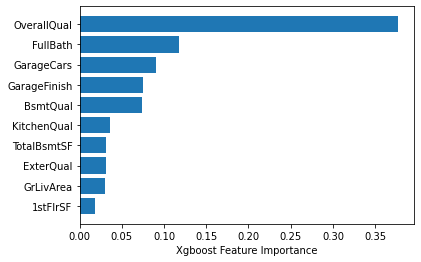

In [ ]:
#The following calculation of feature importance is based on the default gain type:  the average gain across all splits where feature was used.


predictors = num_vars + ordinal_cat
predictors = [col for col in predictors if col not in ['Id','SalePrice']]
y = df['SalePrice'].values
X = df[predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)

sorted_idx = xgb.feature_importances_.argsort()
most_imp_xgb_feats = []
for feat in sorted_idx:
    most_imp_xgb_feats.append(predictors[feat])

plt.barh(most_imp_xgb_feats[-10:], xgb.feature_importances_[sorted_idx][-10:])
plt.xlabel("Xgboost Feature Importance")


Text(0.5, 0, 'Permutation Importance')

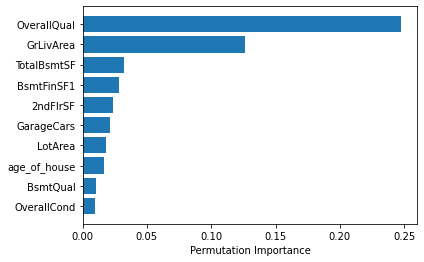

In [ ]:
perm_importance = permutation_importance(xgb, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
most_imp_xgb_perm_feats = []
for feat in sorted_idx:
    most_imp_xgb_perm_feats.append(predictors[feat])

plt.barh(most_imp_xgb_perm_feats[-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")

In [ ]:
#I take union of the top 5 features (model only trained for numerical and ordinal)

subset_of_ordinal_numerical_feats = list(set(most_imp_xgb_feats[-5:] +  most_imp_xgb_perm_feats[-5:]))
print("Features selected : ")
print(subset_of_ordinal_numerical_feats)

#Further recursive feature elimination/addition can also be used, I tried them and arrived at the similar subset of features
#Since they're very computationally expensive and I did not get any additonal beenefit from them, I excluded them in the pipeline

Features selected : 
['BsmtQual', 'GrLivArea', 'GarageCars', 'GarageFinish', 'TotalBsmtSF', 'BsmtFinSF1', 'OverallQual', 'FullBath', '2ndFlrSF']


## Model Hyperparameter Tuning

In [ ]:
df[nominal_cat]

,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,Heating,Electrical,Functional,Fireplaces,FireplaceQu,GarageType,PavedDrive,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,remodelled_yesno,MoSold
86,60,3,0,3,0,1,1,2,2,0,5,1,1,12,13,3,2,2,1,5,6,1,4,3,2,0,1,1,8,4,1,3
692,60,3,0,1,0,1,2,2,2,0,5,3,1,8,8,2,2,3,1,5,6,2,4,1,2,0,1,1,8,4,0,4
570,90,3,0,1,0,1,1,2,2,2,2,1,1,6,6,2,1,1,1,5,6,0,0,5,2,0,1,1,8,4,1,11
754,20,3,0,0,0,1,1,2,2,0,2,1,1,9,10,3,1,1,1,5,6,0,0,5,2,0,1,1,8,4,0,7
917,20,3,0,0,0,1,0,2,2,0,2,1,1,12,13,3,1,1,1,1,6,0,0,1,2,0,1,1,8,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,120,3,0,0,0,1,2,2,2,4,2,1,1,5,5,3,2,2,1,5,6,0,0,1,2,0,1,1,8,4,1,8
726,20,3,0,1,0,2,1,2,2,0,2,3,1,13,10,2,1,1,1,5,6,1,4,1,2,0,1,1,8,4,0,12
477,60,3,0,0,0,1,2,2,2,0,5,3,1,12,13,2,2,2,1,5,6,1,4,3,2,0,1,1,8,4,1,3
287,20,3,0,1,0,2,1,2,2,0,2,1,1,6,6,3,1,1,1,5,6,0,0,6,2,0,1,1,8,4,1,6


In [ ]:
df_hotencoded = pd.get_dummies(df[subset_of_ordinal_numerical_feats+nominal_cat+['SalePrice']], columns = nominal_cat)
print("Final Shape of Dataset : ",df_hotencoded.shape)

predictors = [col for col in df_hotencoded.columns if col not in ['Id','SalePrice']]
y = df_hotencoded['SalePrice'].values
X = df_hotencoded[predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
print("Shape of Training set : {} and Validation set : {}".format(X_train.shape,X_test.shape))

Final Shape of Dataset :  (1456, 208)
Shape of Training set : (1092, 207) and Validation set : (364, 207)


Hyperparameter Tuning?


---
1. There are multiple hparams in xgboost - tree based, regularization based, learning rate. 
2. The theoretically sound method would be to start with tree based features because they impact the most and proceed to regularization ones.
3. I am using grid search cv, to get the parameters that perform best on average. This decreases variance in estimates and avoids overfitting as well. 


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Tree parameters

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,n_estimators=100),cv=5,param_grid = param_test1)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.8409053507900882)

In [ ]:
param_test2 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,max_depth=3,min_child_weight=5),cv=5,param_grid = param_test2)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'reg_alpha': 100}, 0.8410784567342061)

[13:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance report on Validation Set

Root mean squared error on validation : 23834.892070240217
Root mean squared error on train : 12125.587490921831


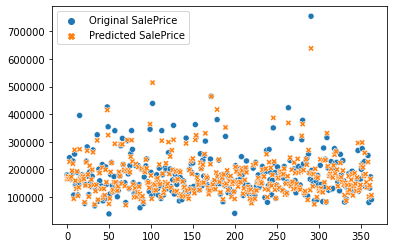

In [ ]:
#FINAL PREDICTIONS - the model performs poorly. 

from sklearn.metrics import mean_squared_error

final_model = XGBRegressor(learning_rate =0.1,max_depth=5,min_child_weight=5,reg_alpha=100)
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

results = pd.DataFrame()
results['Original SalePrice'] = y_test
results['Predicted SalePrice'] = y_pred
sns.scatterplot(data=results)

print("Performance report on Validation Set\n")
print("Root mean squared error on validation : {}".format(math.sqrt(mean_squared_error(y_test,y_pred))))
print("Root mean squared error on train : {}".format(math.sqrt(mean_squared_error(y_train,y_pred_train))))

Interpretation

---
Since, both training and validation rmse are substantially high, we can conclude that the model is underfitting. Since, the purpose here is interpretation and diagnosis, I am not retraining it but possible reasons could be :
1. Curse of dimensionality = drop some cat features
2. Lack of complexity in the model = the above parameter tuning should be done over a larger space with higher resolution. Parameters like max depth and n estimators should be increased and regularization should be decreased.


Using Bayesian Optimization for quicker and efficient parameter tuning

In [ ]:
#Defining space for bayesian optimization

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators',100,1000,100),
        'seed': 123
    }


def objective(space):
    clf=XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,eval_set=evaluation, eval_metric='rmse',early_stopping_rounds=10,verbose=False)
    y_pred = clf.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test,y_pred))
    print ("RMSE:", rmse)

    return {'loss': rmse, 'status': STATUS_OK }


################
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


[17:52:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:
42560.81051859797
[17:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:
43357.12610402124
[17:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:
41255.361639428156
[17:52:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:
41205.76891650003
[17:52:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:
39010.6004055308
[17:52:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:
38440.96981086716
[17:52:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecat

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance report on Validation Set

Root mean squared error on validation : 30577.54470195408
Root mean squared error on train : 5461.578343299673


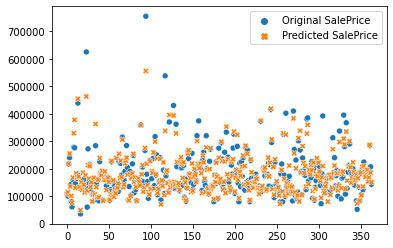

In [ ]:
#Testing after final hparams tuning 

print("Selected hparams ")
print(best_hyperparams)
print("\n")

final_model = XGBRegressor(colsample_bytree=0.8,gamma=2,max_depth=4,min_child_weight=0,n_estimators=600,reg_alpha=167,reg_lambda=0.48)
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

results = pd.DataFrame()
results['Original SalePrice'] = y_test
results['Predicted SalePrice'] = y_pred
sns.scatterplot(data=results)

print("Performance report on Validation Set\n")
print("Root mean squared error on validation : {}".format(math.sqrt(mean_squared_error(y_test,y_pred))))
print("Root mean squared error on train : {}".format(math.sqrt(mean_squared_error(y_train,y_pred_train))))

Does the model perform better on a subset?


---

In order to check this, I repeat the fitting+predicting like above on 2 subsets of the dataframe, identified by individual clusters. 
For this I'll use the model which gave the best validation rmse



In [ ]:
#Cluster 0
df_hotencoded = pd.get_dummies(df.loc[df['cluster']==0][subset_of_ordinal_numerical_feats+nominal_cat+['SalePrice']], columns = nominal_cat)
print("Final Shape of Dataset : ",df_hotencoded.shape)

predictors = [col for col in df_hotencoded.columns if col not in ['Id','SalePrice']]
y = df_hotencoded['SalePrice'].values
X = df_hotencoded[predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=12)
print("Shape of Training set : {} and Validation set : {}".format(X_train.shape,X_test.shape))

final_model = XGBRegressor(learning_rate =0.1,max_depth=5,min_child_weight=5,reg_alpha=100)
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

print("Performance report on Validation Set\n")
print("Root mean squared error on validation : {}".format(math.sqrt(mean_squared_error(y_test,y_pred))))
print("Root mean squared error on train : {}".format(math.sqrt(mean_squared_error(y_train,y_pred_train))))

Final Shape of Dataset :  (817, 194)
Shape of Training set : (81, 193) and Validation set : (736, 193)
[13:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance report on Validation Set

Root mean squared error on validation : 51938.42015310054
Root mean squared error on train : 6492.027418303161


In [ ]:
#Cluster 1
df_hotencoded = pd.get_dummies(df.loc[df['cluster']==1][subset_of_ordinal_numerical_feats+nominal_cat+['SalePrice']], columns = nominal_cat)
print("Final Shape of Dataset : ",df_hotencoded.shape)

predictors = [col for col in df_hotencoded.columns if col not in ['Id','SalePrice']]
y = df_hotencoded['SalePrice'].values
X = df_hotencoded[predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=12)
print("Shape of Training set : {} and Validation set : {}".format(X_train.shape,X_test.shape))

final_model = XGBRegressor(learning_rate =0.1,max_depth=5,min_child_weight=5,reg_alpha=100)
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

print("Performance report on Validation Set\n")
print("Root mean squared error on validation : {}".format(math.sqrt(mean_squared_error(y_test,y_pred))))
print("Root mean squared error on train : {}".format(math.sqrt(mean_squared_error(y_train,y_pred_train))))

Final Shape of Dataset :  (639, 196)
Shape of Training set : (63, 195) and Validation set : (576, 195)
[13:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance report on Validation Set

Root mean squared error on validation : 25091.997130559375
Root mean squared error on train : 3581.787542554695


The model is comparatively better on houses belonging to cluster 1

In [ ]:
df_cluster1 = df.loc[df['cluster']==1]
df_cluster1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Sum_SF,Sum_SF_basement,diff,remodelled_yesno,age_of_house,cluster
570,571,90,3,74.0,114.459602,0,1,0,1,1,2,2,2,2,5,5,94,94,1,1,6,6,2,108.0,2,2,1,3,3,1,231.0,1.0,1497.0,1728.0,1,3,5,1728.0,0.0,0.0,1728.0,0,0,2,0,6,2,10,6,0,0,5,1,2,576.0,3,2,0.0,0.0,0.0,0.0,0,1,1,11,137,8,4,142600.0,1728,1728,True,1,43,1
917,918,20,3,78.0,130.919830,0,0,0,1,0,2,2,0,2,4,6,85,85,1,1,12,13,3,0.0,2,2,1,3,3,1,1059.0,1.0,75.0,1134.0,1,5,1,1229.0,0.0,0.0,1229.0,0,0,1,0,3,2,6,6,0,0,1,2,1,284.0,3,2,0.0,0.0,0.0,0.0,0,1,1,4,138,8,4,135000.0,1229,1134,True,1,53,1
154,155,30,4,84.0,106.489433,0,0,0,2,0,2,2,0,2,6,5,52,79,1,1,13,14,3,0.0,2,2,0,3,3,1,0.0,1.0,1200.0,1200.0,1,3,1,1200.0,0.0,0.0,1200.0,0,0,1,0,4,2,7,6,0,0,5,1,1,312.0,2,2,0.0,0.0,228.0,0.0,0,1,1,3,135,8,3,125000.0,1200,1200,True,0,56,1
904,905,20,3,100.0,78.568443,0,1,0,1,1,2,2,0,2,5,6,96,96,1,1,6,14,2,75.0,2,2,1,3,3,1,599.0,1.0,277.0,876.0,1,3,5,902.0,0.0,0.0,902.0,0,0,1,0,3,2,6,6,0,0,1,1,1,288.0,3,2,0.0,0.0,0.0,0.0,1,1,1,8,136,8,4,125500.0,902,876,True,1,40,1
859,860,60,3,100.0,105.019043,0,1,0,2,1,3,2,0,5,6,7,97,113,1,1,6,6,2,220.0,2,2,1,3,3,1,619.0,1.0,435.0,1054.0,1,3,5,1512.0,1142.0,0.0,2654.0,1,0,2,1,4,3,9,6,1,4,1,1,2,619.0,3,2,0.0,65.0,0.0,222.0,0,1,1,8,135,8,4,250000.0,2654,1054,True,0,22,1


Thank you!